## Rossmann Store Sales
1. 문제의 정의 : 해결하려는 문제는 무엇인가?
 - Rossmann은 유럽 7개국에서 3,000개 이상의 약국을 운영하고 있다.
 - 매장의 매니저들은 하루 매출을 최대 6주 전에 미리 예측한다.
 - 상점 판매는 판촉, 경쟁, 학교와 주 휴일, 계절적 요인과 지역을 포함한 많은 요인에 영향을 받는다.
 - 독일 전역에 위치한 1,115개 매장에 대해 6주간 일일 매출(Sales)를 예측하는 것이 Target

## Feature 분석
 - Store : store ID(Unique)
 - Sales : 특정 날짜의 매출량 (Target)
 - Customers : 손님수
 - Open : 1 = open, 0 = colosed
 - StateHoliday : a = public holday, b = Easter holiday, c = Chrismas, 0 = None
 - SchoolHoliday : 
 - StoreType : a, b, c, d
 - Assortment : a = basic, b = extra, c = extended
 - CompetitionDistance : 경쟁업체와의 거리(미터)
 - CompetitionOpenSince[Month/Year] : 가장 가까운 경쟁 업체의 오픈한 달과 연도
 - Promo : 해당 날에 프로모션을 했는지 아닌지
 - Promo2 : 지속적인 연속 홍보 0 = False, 1 = True
 - Promo2Since[Year/Week] : Promo2를 시작한 연도와 주
 - PromoInterval : 프로모션이 새로 시작되는 월을 명명 Ex) Feb,May,Aug,Nov

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import display
from sklearn.linear_model import LinearRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import KFold,RandomizedSearchCV
from sklearn.decomposition import PCA

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
train_data = pd.read_csv("./input/train.csv")
test_data = pd.read_csv("./input/test.csv")
store_data = pd.read_csv("./input/store.csv")
sample_data = pd.read_csv("./input/sample_submission.csv")

display(train_data.head(10).T)
display(train_data.describe())
display(store_data.head(10).T)
display(store_data.describe())

/home/hars/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


0           1           2           3           4  \
Store                   1           2           3           4           5   
DayOfWeek               5           5           5           5           5   
Date           2015-07-31  2015-07-31  2015-07-31  2015-07-31  2015-07-31   
Sales                5263        6064        8314       13995        4822   
Customers             555         625         821        1498         559   
Open                    1           1           1           1           1   
Promo                   1           1           1           1           1   
StateHoliday            0           0           0           0           0   
SchoolHoliday           1           1           1           1           1   

                        5           6           7           8           9  
Store                   6           7           8           9          10  
DayOfWeek               5           5           5           5           5  
Date           2015-07-31  2015-07-31  2015-07-31  2015-07-31  2015-07-31  
Sales                5651       15344        8492        8565        7185  
Customers             589        1414         833         687         681  
Open                    1           1           1           1           1  
Promo                   1           1           1           1           1  
StateHoliday            0           0           0           0           0  
SchoolHoliday           1           1           1           1           1

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  
count  1.017209e+06   1.017209e+06  
mean   3.815145e-01   1.786467e-01  
std    4.857586e-01   3.830564e-01  
min    0.000000e+00   0.000000e+00  
25%    0.000000e+00   0.000000e+00  
50%    0.000000e+00   0.000000e+00  
75%    1.000000e+00   0.000000e+00  
max    1.000000e+00   1.000000e+00

0                1                2     3  \
Store                         1                2                3     4   
StoreType                     c                a                a     c   
Assortment                    a                a                a     c   
CompetitionDistance        1270              570            14130   620   
CompetitionOpenSinceMonth     9               11               12     9   
CompetitionOpenSinceYear   2008             2007             2006  2009   
Promo2                        0                1                1     0   
Promo2SinceWeek             NaN               13               14   NaN   
Promo2SinceYear             NaN             2010             2011   NaN   
PromoInterval               NaN  Jan,Apr,Jul,Oct  Jan,Apr,Jul,Oct   NaN   

                               4     5      6     7     8     9  
Store                          5     6      7     8     9    10  
StoreType                      a     a      a     a     a     a  
Assortment                     a     a      c     a     c     a  
CompetitionDistance        29910   310  24000  7520  2030  3160  
CompetitionOpenSinceMonth      4    12      4    10     8     9  
CompetitionOpenSinceYear    2015  2013   2013  2014  2000  2009  
Promo2                         0     0      0     0     0     0  
Promo2SinceWeek              NaN   NaN    NaN   NaN   NaN   NaN  
Promo2SinceYear              NaN   NaN    NaN   NaN   NaN   NaN  
PromoInterval                NaN   NaN    NaN   NaN   NaN   NaN

Store  CompetitionDistance  CompetitionOpenSinceMonth  \
count  1115.00000          1112.000000                 761.000000   
mean    558.00000          5404.901079                   7.224704   
std     322.01708          7663.174720                   3.212348   
min       1.00000            20.000000                   1.000000   
25%     279.50000           717.500000                   4.000000   
50%     558.00000          2325.000000                   8.000000   
75%     836.50000          6882.500000                  10.000000   
max    1115.00000         75860.000000                  12.000000   

       CompetitionOpenSinceYear       Promo2  Promo2SinceWeek  Promo2SinceYear  
count                761.000000  1115.000000       571.000000       571.000000  
mean                2008.668857     0.512108        23.595447      2011.763573  
std                    6.195983     0.500078        14.141984         1.674935  
min                 1900.000000     0.000000         1.000000      2009.000000  
25%                 2006.000000     0.000000        13.000000      2011.000000  
50%                 2010.000000     1.000000        22.000000      2012.000000  
75%                 2013.000000     1.000000        37.000000      2013.000000  
max                 2015.000000     1.000000        50.000000      2015.000000

In [3]:
result_data = pd.merge(train_data, store_data, on='Store')
display(result_data.head(10).T)
display(result_data.describe())
result_data.nunique()

0           1           2           3  \
Store                               1           1           1           1   
DayOfWeek                           5           4           3           2   
Date                       2015-07-31  2015-07-30  2015-07-29  2015-07-28   
Sales                            5263        5020        4782        5011   
Customers                         555         546         523         560   
Open                                1           1           1           1   
Promo                               1           1           1           1   
StateHoliday                        0           0           0           0   
SchoolHoliday                       1           1           1           1   
StoreType                           c           c           c           c   
Assortment                          a           a           a           a   
CompetitionDistance              1270        1270        1270        1270   
CompetitionOpenSinceMonth           9           9           9           9   
CompetitionOpenSinceYear         2008        2008        2008        2008   
Promo2                              0           0           0           0   
Promo2SinceWeek                   NaN         NaN         NaN         NaN   
Promo2SinceYear                   NaN         NaN         NaN         NaN   
PromoInterval                     NaN         NaN         NaN         NaN   

                                    4           5           6           7  \
Store                               1           1           1           1   
DayOfWeek                           1           7           6           5   
Date                       2015-07-27  2015-07-26  2015-07-25  2015-07-24   
Sales                            6102           0        4364        3706   
Customers                         612           0         500         459   
Open                                1           0           1           1   
Promo                               1           0           0           0   
StateHoliday                        0           0           0           0   
SchoolHoliday                       1           0           0           0   
StoreType                           c           c           c           c   
Assortment                          a           a           a           a   
CompetitionDistance              1270        1270        1270        1270   
CompetitionOpenSinceMonth           9           9           9           9   
CompetitionOpenSinceYear         2008        2008        2008        2008   
Promo2                              0           0           0           0   
Promo2SinceWeek                   NaN         NaN         NaN         NaN   
Promo2SinceYear                   NaN         NaN         NaN         NaN   
PromoInterval                     NaN         NaN         NaN         NaN   

                                    8           9  
Store                               1           1  
DayOfWeek                           4           3  
Date                       2015-07-23  2015-07-22  
Sales                            3769        3464  
Customers                         503         463  
Open                                1           1  
Promo                               0           0  
StateHoliday                        0           0  
SchoolHoliday                       0           0  
StoreType                           c           c  
Assortment                          a           a  
CompetitionDistance              1270        1270  
CompetitionOpenSinceMonth           9           9  
CompetitionOpenSinceYear         2008        2008  
Promo2                              0           0  
Promo2SinceWeek                   NaN         NaN  
Promo2SinceYear                   NaN         NaN  
PromoInterval                     NaN         NaN

Store     DayOfWeek         Sales     Customers          Open  \
count  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06  1.017209e+06   
mean   5.584297e+02  3.998341e+00  5.773819e+03  6.331459e+02  8.301067e-01   
std    3.219087e+02  1.997391e+00  3.849926e+03  4.644117e+02  3.755392e-01   
min    1.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    2.800000e+02  2.000000e+00  3.727000e+03  4.050000e+02  1.000000e+00   
50%    5.580000e+02  4.000000e+00  5.744000e+03  6.090000e+02  1.000000e+00   
75%    8.380000e+02  6.000000e+00  7.856000e+03  8.370000e+02  1.000000e+00   
max    1.115000e+03  7.000000e+00  4.155100e+04  7.388000e+03  1.000000e+00   

              Promo  SchoolHoliday  CompetitionDistance  \
count  1.017209e+06   1.017209e+06         1.014567e+06   
mean   3.815145e-01   1.786467e-01         5.430086e+03   
std    4.857586e-01   3.830564e-01         7.715324e+03   
min    0.000000e+00   0.000000e+00         2.000000e+01   
25%    0.000000e+00   0.000000e+00         7.100000e+02   
50%    0.000000e+00   0.000000e+00         2.330000e+03   
75%    1.000000e+00   0.000000e+00         6.890000e+03   
max    1.000000e+00   1.000000e+00         7.586000e+04   

       CompetitionOpenSinceMonth  CompetitionOpenSinceYear        Promo2  \
count              693861.000000             693861.000000  1.017209e+06   
mean                    7.222866               2008.690228  5.005638e-01   
std                     3.211832                  5.992644  4.999999e-01   
min                     1.000000               1900.000000  0.000000e+00   
25%                     4.000000               2006.000000  0.000000e+00   
50%                     8.000000               2010.000000  1.000000e+00   
75%                    10.000000               2013.000000  1.000000e+00   
max                    12.000000               2015.000000  1.000000e+00   

       Promo2SinceWeek  Promo2SinceYear  
count    509178.000000    509178.000000  
mean         23.269093      2011.752774  
std          14.095973         1.662870  
min           1.000000      2009.000000  
25%          13.000000      2011.000000  
50%          22.000000      2012.000000  
75%          37.000000      2013.000000  
max          50.000000      2015.000000

Store                         1115
DayOfWeek                        7
Date                           942
Sales                        21734
Customers                     4086
Open                             2
Promo                            2
StateHoliday                     5
SchoolHoliday                    2
StoreType                        4
Assortment                       3
CompetitionDistance            654
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        23
Promo2                           2
Promo2SinceWeek                 24
Promo2SinceYear                  7
PromoInterval                    3
dtype: int64

In [5]:
for i in result_data.keys():
    print(i, result_data[i].isnull().sum())

Store 0
DayOfWeek 0
Date 0
Sales 0
Customers 0
Open 0
Promo 0
StateHoliday 0
SchoolHoliday 0
StoreType 0
Assortment 0
CompetitionDistance 2642
CompetitionOpenSinceMonth 323348
CompetitionOpenSinceYear 323348
Promo2 0
Promo2SinceWeek 508031
Promo2SinceYear 508031
PromoInterval 508031


Text(0.5,0,'Sales')

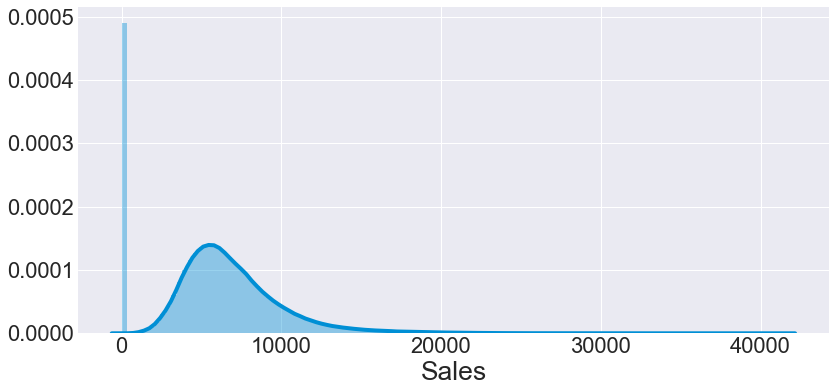

In [6]:
import matplotlib as mpl

mpl.rcParams.update({'font.size': 22, 'figure.figsize': (12,6)})
sns.set_style("darkgrid")

# Target 변수의 분포 확인
sns.distplot(result_data['Sales'], bins=120)
plt.xlabel('Sales')

Text(0.5,0,'Customers')

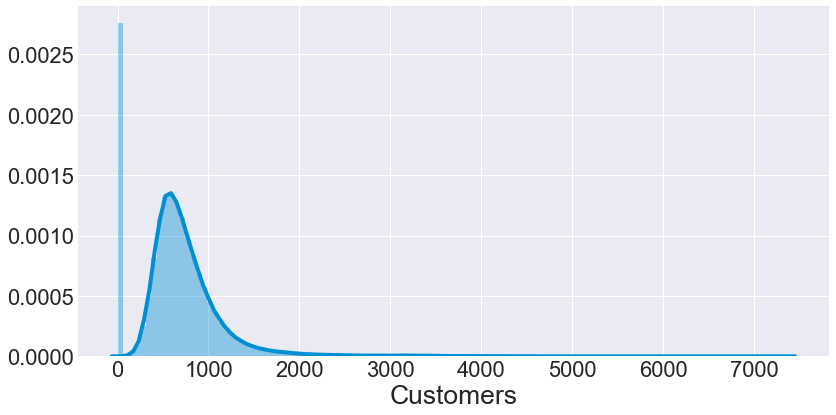

In [30]:
sns.distplot(result_data['Customers'], bins=120)
plt.xlabel('Customers')

Sales                  0
CompetitionDistance    0
dtype: int64

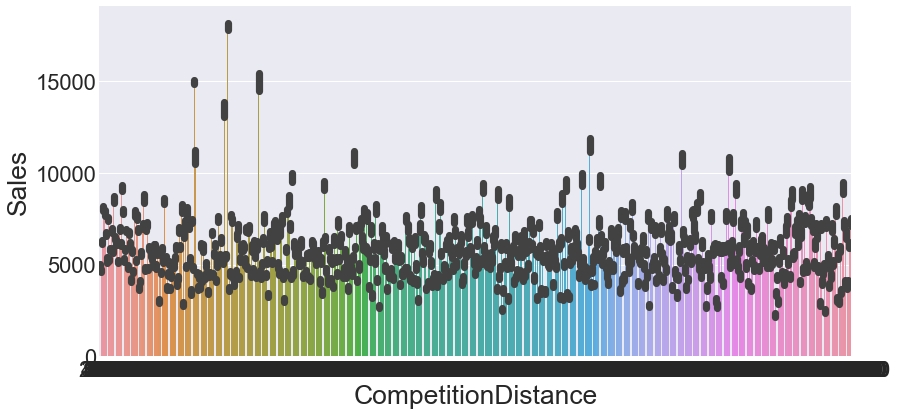

In [31]:
compet_proc = result_data[["Sales","CompetitionDistance"]].dropna()
display(compet_proc.isnull().sum())
sns.barplot(x='CompetitionDistance', y='Sales', data=compet_proc)

CompetitionDistance       Sales
0                  0.0    11983829
1                  1.0  5861196794

CompetitionDistance        Sales
0                  0.0  4535.892884
1                  1.0  5777.042614

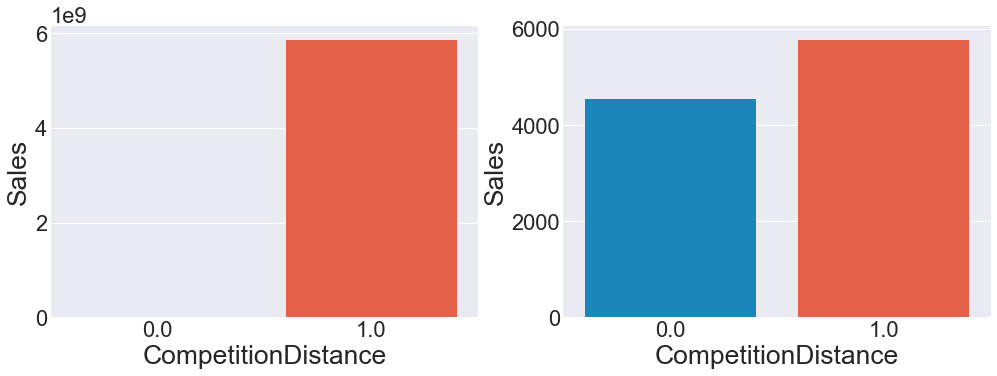

In [188]:
compet_proc = result_data[['Sales', 'CompetitionDistance']].fillna(0)
compet_proc.loc[compet_proc['CompetitionDistance'] > 0, 'CompetitionDistance'] = 1

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
compet_sum = compet_proc.groupby(['CompetitionDistance'],as_index=False).sum()
compet_mean = compet_proc.groupby(['CompetitionDistance'],as_index=False).mean()
display(compet_sum)
display(compet_mean)
sns.barplot(x='CompetitionDistance', y='Sales', data=compet_sum, ax=ax1)
sns.barplot(x='CompetitionDistance', y='Sales', data=compet_mean, ax=ax2)

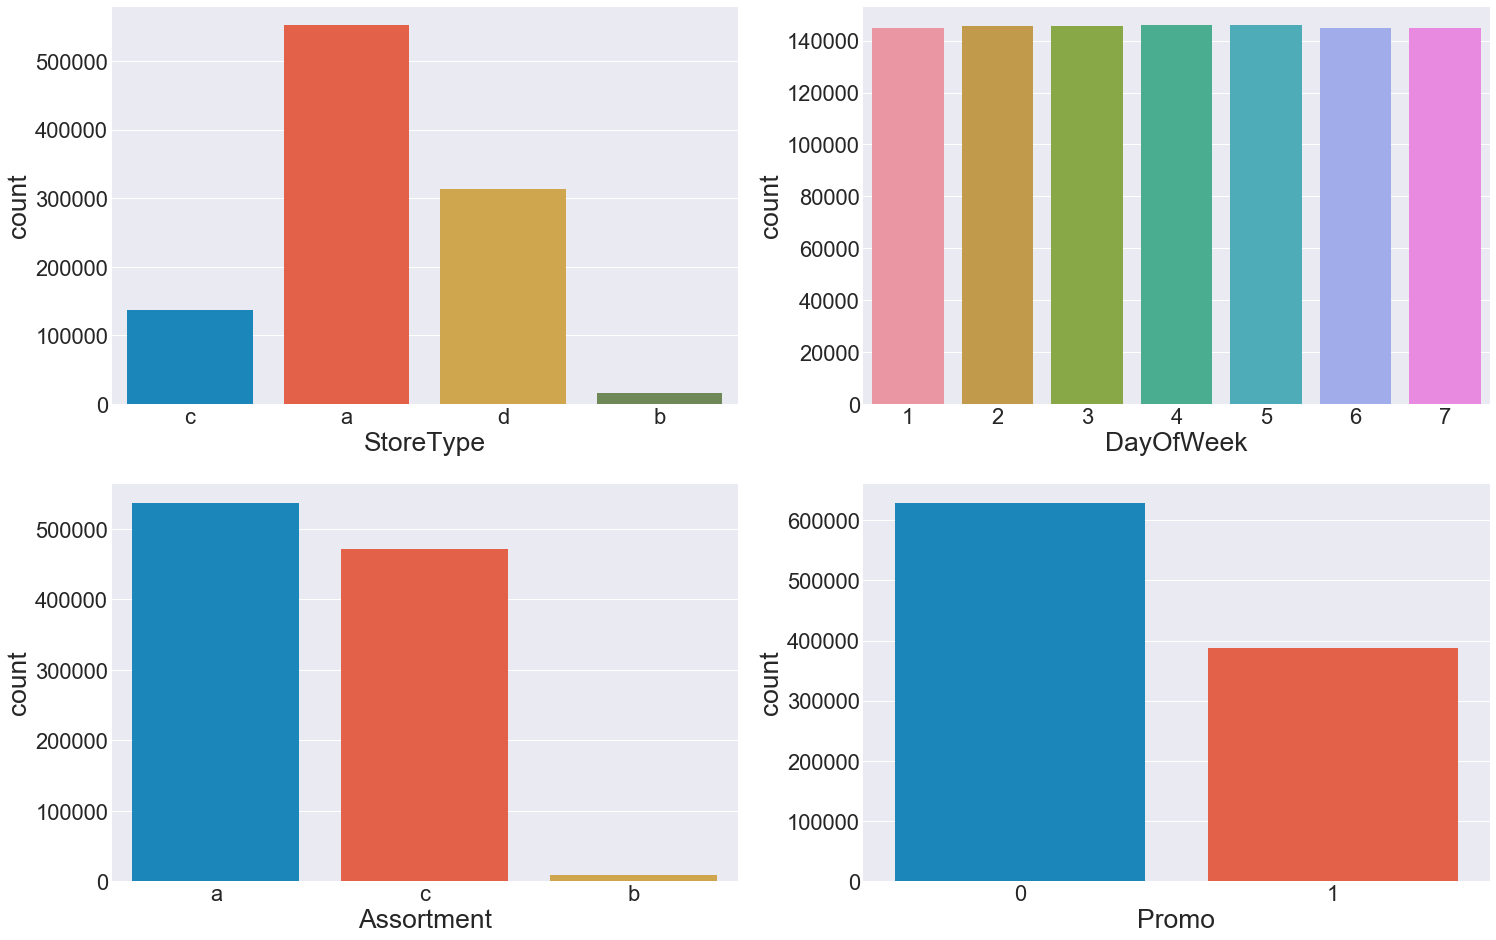

In [189]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(22, 15))

sns.countplot(x='StoreType', data=result_data, ax=ax1)
sns.countplot(x='DayOfWeek', data=result_data, ax=ax2)
sns.countplot(x='Assortment', data=result_data, ax=ax3)
sns.countplot(x='Promo', data=result_data, ax=ax4)

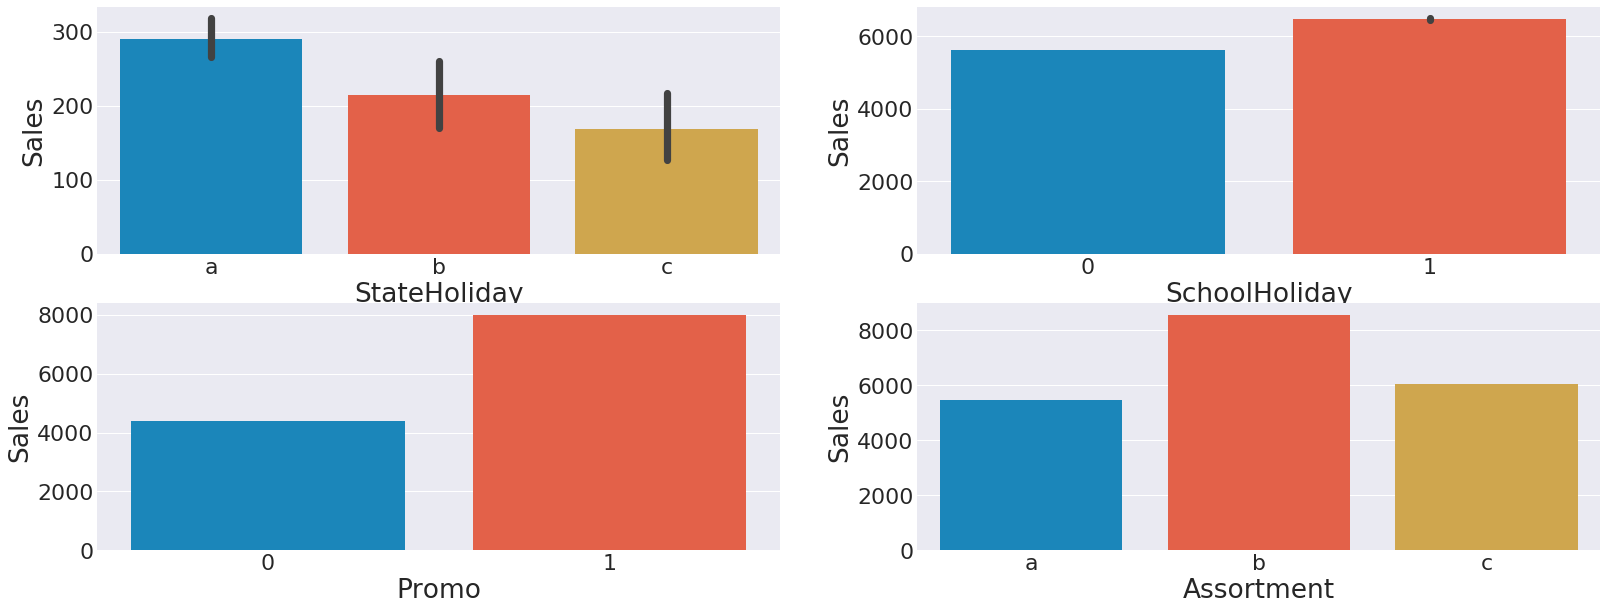

In [10]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(24, 10))

sns.barplot(x='StateHoliday', y='Sales', data=result_data, order=['a', 'b', 'c'], ax=ax1)
sns.barplot(x='SchoolHoliday', y='Sales', data=result_data, ax=ax2)
promo_proc = result_data[["Promo", "Sales"]].groupby(['Promo'],as_index=False).mean()
sns.barplot(x='Promo', y='Sales', data=promo_proc, ax=ax3)
assort_proc = result_data[["Assortment", "Sales"]].groupby(['Assortment'],as_index=False).mean()
sns.barplot(x='Assortment', y='Sales', data=assort_proc, ax=ax4)

In [190]:
promo_proc2 = result_data[["Promo", "Sales", "Promo2"]].groupby(['Promo', 'Promo2']).sum()
display(promo_proc2)
promo_proc2 = result_data[["Promo", "Sales", "Promo2"]].groupby(['Promo', 'Promo2']).mean()
display(promo_proc2)

Sales
Promo Promo2            
0     0       1482612096
      1       1289362241
1     0       1628930532
      1       1472275754

Sales
Promo Promo2             
0     0       4722.190854
      1       4091.109464
1     0       8393.780052
      1       7588.424429

Sales            0
PromoInterval    0
dtype: int64

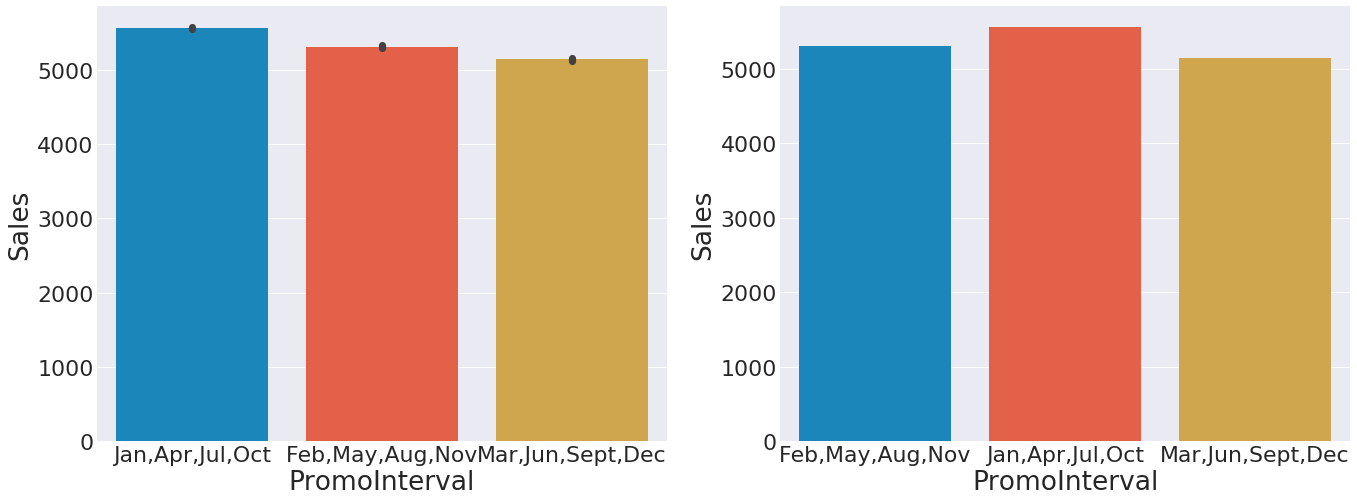

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

pro_interval = result_data[['Sales','PromoInterval']].dropna()
pro_interval2 = pro_interval.groupby(['PromoInterval'],as_index=False).mean()
display(pro_interval.isnull().sum())
sns.barplot(x='PromoInterval', y='Sales', data=pro_interval, ax=ax1)
sns.barplot(x='PromoInterval', y='Sales', data=pro_interval2, ax=ax2)

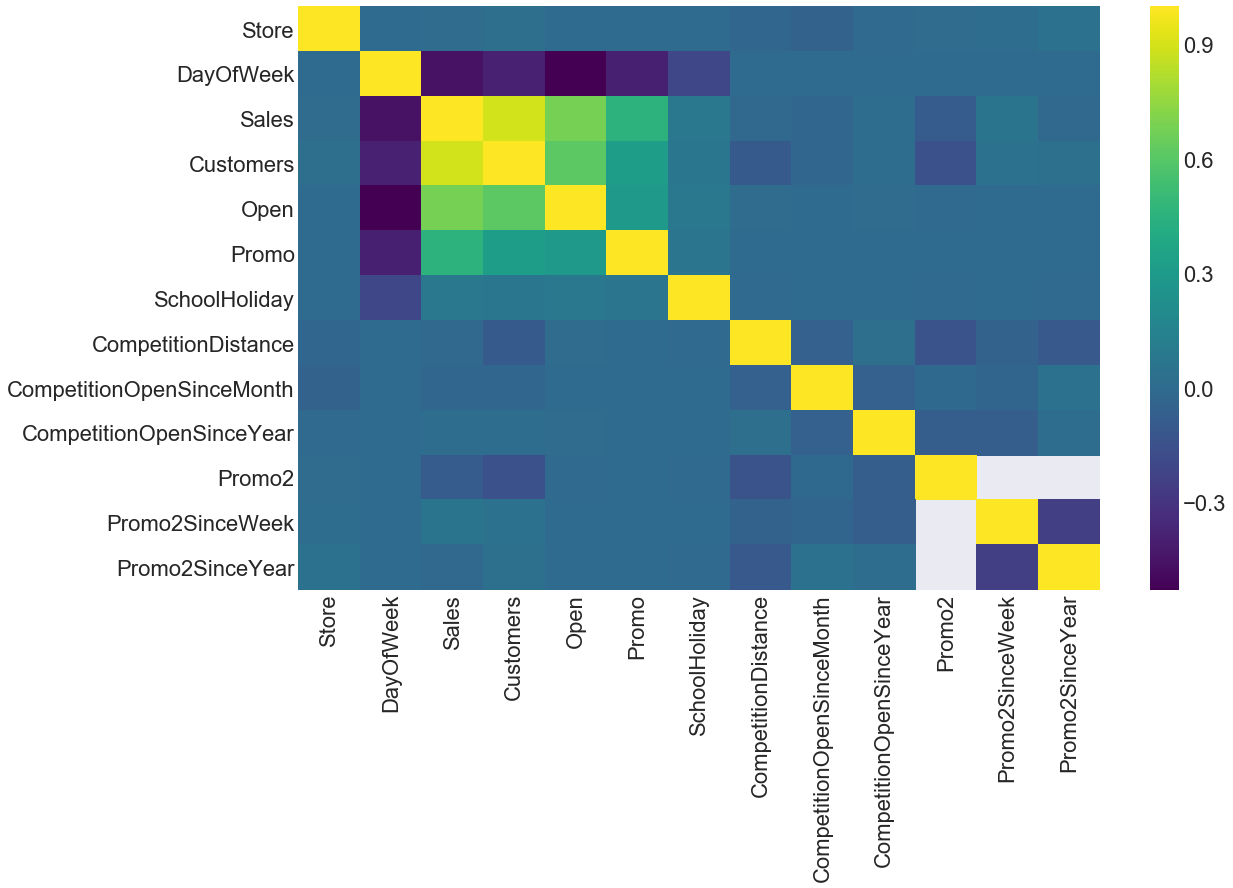

In [191]:
# 속성들의 상관관계를 확인
cor = result_data.corr()
plt.figure(figsize=(16, 10))

sns.heatmap(cor, cmap='viridis')

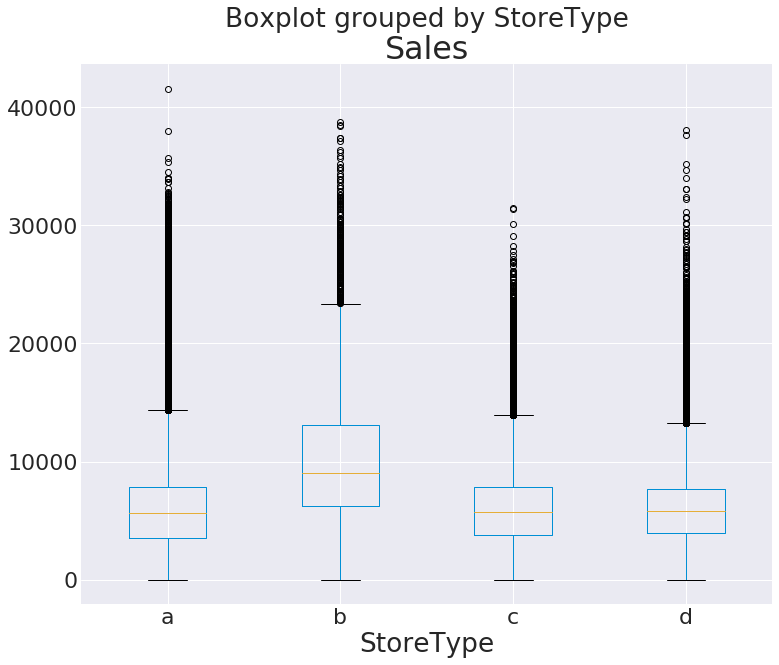

In [14]:
result_data.boxplot('Sales', by='StoreType', figsize=(12,10))

In [7]:
result_data["StateHoliday"].unique()

array(['0', 'a', 'b', 'c', 0], dtype=object)

In [60]:
#compet_sin = result_data[['Sales','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']].groupby(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth']).sum()
#display(compet_sin)
compet_sin = result_data[['Sales','CompetitionOpenSinceYear','CompetitionOpenSinceMonth']].groupby(['CompetitionOpenSinceYear','CompetitionOpenSinceMonth']).mean()
display(compet_sin.unstack('CompetitionOpenSinceMonth'))

Sales                                         \
CompetitionOpenSinceMonth         1.0          2.0          3.0          4.0    
CompetitionOpenSinceYear                                                        
1900.0                     6889.460422          NaN          NaN          NaN   
1961.0                             NaN          NaN          NaN          NaN   
1990.0                             NaN          NaN          NaN          NaN   
1994.0                             NaN          NaN          NaN          NaN   
1995.0                             NaN          NaN          NaN          NaN   
1998.0                             NaN          NaN          NaN          NaN   
1999.0                             NaN          NaN          NaN          NaN   
2000.0                             NaN          NaN  7763.773885          NaN   
2001.0                             NaN          NaN  5053.625265  5176.120488   
2002.0                             NaN  7084.862793  9744.599788  5767.020878   
2003.0                             NaN          NaN  6377.848195  6118.105803   
2004.0                             NaN  3307.213376          NaN  5622.877212   
2005.0                     9947.043878  4667.072187  5997.636943  5511.377982   
2006.0                     4987.748408  6457.621019  7468.713648  5802.217091   
2007.0                     3178.059979          NaN  4917.678274  5600.962751   
2008.0                     4997.840369  4898.565481  4755.475357  6645.878052   
2009.0                             NaN  6311.597134  6531.235669  5964.742675   
2010.0                             NaN  5235.814933  5941.634820          NaN   
2011.0                     6300.434183  5393.242038  5880.280888  5918.903072   
2012.0                     6418.742569  4605.766491  5147.368233  6090.886412   
2013.0                             NaN  5966.958295  6868.340928  5830.266149   
2014.0                     4252.394459  4284.268931  6058.421630  5085.199180   
2015.0                     4267.188960  4800.262739  4922.535714  5264.466973   

                                                                   \
CompetitionOpenSinceMonth          5.0          6.0          7.0    
CompetitionOpenSinceYear                                            
1900.0                              NaN          NaN          NaN   
1961.0                              NaN          NaN          NaN   
1990.0                              NaN  6206.414544  5721.635173   
1994.0                              NaN          NaN          NaN   
1995.0                              NaN          NaN          NaN   
1998.0                              NaN          NaN  6091.211253   
1999.0                      7016.811040          NaN          NaN   
2000.0                              NaN          NaN  9814.584433   
2001.0                      4903.074841          NaN  5223.387473   
2002.0                      4602.759023          NaN  4121.648620   
2003.0                              NaN  6263.037599  3979.624204   
2004.0                              NaN  4964.274406  4407.963061   
2005.0                      4315.160297  4406.237792  5129.544450   
2006.0                      8794.973461  3916.657652  4251.292941   
2007.0                      5708.330414  6014.355980  5429.362527   
2008.0                      5539.227828  7272.917413  5740.154989   
2009.0                      5939.174706  7124.102442  5253.446176   
2010.0                      4200.954087  6044.001213  5503.242808   
2011.0                      7887.573940  7196.250000  4106.967091   
2012.0                      3274.961783  6187.652065  4186.300062   
2013.0                     10466.075132          NaN  6095.541610   
2014.0                      7463.510598  6858.142831  7008.577435   
2015.0                      4295.641368  7634.747983  6068.167271   

                                                                               \
CompetitionOpenSinceMonth         8.0          9.0

In [61]:
promo_day_sale = result_data[['Sales','DayOfWeek', 'Promo', 'Open']].groupby(['Open', 'Promo','DayOfWeek']).mean()
display(promo_day_sale)
# barplot으로 

Sales
Open Promo DayOfWeek             
0    0     1             0.000000
           2             0.000000
           3             0.000000
           4             0.000000
           5             0.000000
           6             0.000000
           7             0.000000
     1     1             0.000000
           2             0.000000
           3             0.000000
           4             0.000000
           5             0.000000
1    0     1          6222.521495
           2          5716.241087
           3          5617.044778
           4          5749.837412
           5          6344.030127
           6          5874.840238
           7          8224.723908
     1     1          9772.784369
           2          8277.201522
           3          7685.077816
           4          7598.070761
           5          7744.066219

In [35]:
school_day_sale = result_data[['Sales','DayOfWeek', 'SchoolHoliday', 'Open']].groupby(['Open', 'SchoolHoliday','DayOfWeek']).mean()
display(school_day_sale)

Sales
Open SchoolHoliday DayOfWeek              
0    0             1              0.000000
                   2              0.000000
                   3              0.000000
                   4              0.000000
                   5              0.000000
                   6              0.000000
                   7              0.000000
     1             1              0.000000
                   2              0.000000
                   3              0.000000
                   4              0.000000
                   5              0.000000
                   6              0.000000
                   7              0.000000
1    0             1           8078.905852
                   2           7083.980016
                   3           6748.115366
                   4           6744.685870
                   5           7140.580298
                   6           5873.787454
                   7           8130.568499
     1             1           8689.168893
                   2           7100.778879
                   3           6660.433767
                   4           6845.617740
                   5           6844.250181
                   6           5929.566017
                   7          12256.182927

In [4]:
result_data['Year'] = pd.DatetimeIndex(result_data['Date']).year
result_data['Month'] = pd.DatetimeIndex(result_data['Date']).month
result_data['Day'] = pd.DatetimeIndex(result_data['Date']).day

In [5]:
display(result_data.head(10).T)

0           1           2           3  \
Store                               1           1           1           1   
DayOfWeek                           5           4           3           2   
Date                       2015-07-31  2015-07-30  2015-07-29  2015-07-28   
Sales                            5263        5020        4782        5011   
Customers                         555         546         523         560   
Open                                1           1           1           1   
Promo                               1           1           1           1   
StateHoliday                        0           0           0           0   
SchoolHoliday                       1           1           1           1   
StoreType                           c           c           c           c   
Assortment                          a           a           a           a   
CompetitionDistance              1270        1270        1270        1270   
CompetitionOpenSinceMonth           9           9           9           9   
CompetitionOpenSinceYear         2008        2008        2008        2008   
Promo2                              0           0           0           0   
Promo2SinceWeek                   NaN         NaN         NaN         NaN   
Promo2SinceYear                   NaN         NaN         NaN         NaN   
PromoInterval                     NaN         NaN         NaN         NaN   
Year                             2015        2015        2015        2015   
Month                               7           7           7           7   
Day                                31          30          29          28   

                                    4           5           6           7  \
Store                               1           1           1           1   
DayOfWeek                           1           7           6           5   
Date                       2015-07-27  2015-07-26  2015-07-25  2015-07-24   
Sales                            6102           0        4364        3706   
Customers                         612           0         500         459   
Open                                1           0           1           1   
Promo                               1           0           0           0   
StateHoliday                        0           0           0           0   
SchoolHoliday                       1           0           0           0   
StoreType                           c           c           c           c   
Assortment                          a           a           a           a   
CompetitionDistance              1270        1270        1270        1270   
CompetitionOpenSinceMonth           9           9           9           9   
CompetitionOpenSinceYear         2008        2008        2008        2008   
Promo2                              0           0           0           0   
Promo2SinceWeek                   NaN         NaN         NaN         NaN   
Promo2SinceYear                   NaN         NaN         NaN         NaN   
PromoInterval                     NaN         NaN         NaN         NaN   
Year                             2015        2015        2015        2015   
Month                               7           7           7           7   
Day                                27          26          25          24   

                                    8           9  
Store                               1           1  
DayOfWeek                           4           3  
Date                       2015-07-23  2015-07-22  
Sales                            3769        3464  
Customers                         503         463  
Open                                1           1  
Promo                               0           0  
StateHoliday                        0           0  
SchoolHoliday                       0           0  
StoreType                           c           c  
Assortment                          a           a  
CompetitionDistance   

In [6]:
result_data['CompetitionDistance'] = result_data['CompetitionDistance'].fillna(0)
result_data.loc[result_data['CompetitionDistance'] > 0, 'CompetitionDistance'] = 1
result_data['CompetitionDistance'].max()

1.0

In [10]:
display(result_data.head(10).T)

0           1           2           3  \
Store                               1           1           1           1   
DayOfWeek                           5           4           3           2   
Date                       2015-07-31  2015-07-30  2015-07-29  2015-07-28   
Sales                            5263        5020        4782        5011   
Customers                         555         546         523         560   
Open                                1           1           1           1   
Promo                               1           1           1           1   
StateHoliday                        0           0           0           0   
SchoolHoliday                       1           1           1           1   
StoreType                           c           c           c           c   
Assortment                          a           a           a           a   
CompetitionDistance              1270        1270        1270        1270   
CompetitionOpenSinceMonth           9           9           9           9   
CompetitionOpenSinceYear         2008        2008        2008        2008   
Promo2                              0           0           0           0   
Promo2SinceWeek                   NaN         NaN         NaN         NaN   
Promo2SinceYear                   NaN         NaN         NaN         NaN   
PromoInterval                     NaN         NaN         NaN         NaN   
Year                             2015        2015        2015        2015   
Month                               7           7           7           7   
Day                                31          30          29          28   

                                    4           5           6           7  \
Store                               1           1           1           1   
DayOfWeek                           1           7           6           5   
Date                       2015-07-27  2015-07-26  2015-07-25  2015-07-24   
Sales                            6102           0        4364        3706   
Customers                         612           0         500         459   
Open                                1           0           1           1   
Promo                               1           0           0           0   
StateHoliday                        0           0           0           0   
SchoolHoliday                       1           0           0           0   
StoreType                           c           c           c           c   
Assortment                          a           a           a           a   
CompetitionDistance              1270        1270        1270        1270   
CompetitionOpenSinceMonth           9           9           9           9   
CompetitionOpenSinceYear         2008        2008        2008        2008   
Promo2                              0           0           0           0   
Promo2SinceWeek                   NaN         NaN         NaN         NaN   
Promo2SinceYear                   NaN         NaN         NaN         NaN   
PromoInterval                     NaN         NaN         NaN         NaN   
Year                             2015        2015        2015        2015   
Month                               7           7           7           7   
Day                                27          26          25          24   

                                    8           9  
Store                               1           1  
DayOfWeek                           4           3  
Date                       2015-07-23  2015-07-22  
Sales                            3769        3464  
Customers                         503         463  
Open                                1           1  
Promo                               0           0  
StateHoliday                        0           0  
SchoolHoliday                       0           0  
StoreType                           c           c  
Assortment                          a           a  
CompetitionDistance   

In [7]:
new_col = ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Year', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo2', 'Month', 'Day']
result_data = result_data[new_col]
display(result_data.head(10).T)

0     1     2     3     4     5     6     7     8     9
Store             1     1     1     1     1     1     1     1     1     1
DayOfWeek         5     4     3     2     1     7     6     5     4     3
Sales          5263  5020  4782  5011  6102     0  4364  3706  3769  3464
Customers       555   546   523   560   612     0   500   459   503   463
Year           2015  2015  2015  2015  2015  2015  2015  2015  2015  2015
Open              1     1     1     1     1     0     1     1     1     1
Promo             1     1     1     1     1     0     0     0     0     0
StateHoliday      0     0     0     0     0     0     0     0     0     0
SchoolHoliday     1     1     1     1     1     0     0     0     0     0
StoreType         c     c     c     c     c     c     c     c     c     c
Assortment        a     a     a     a     a     a     a     a     a     a
Promo2            0     0     0     0     0     0     0     0     0     0
Month             7     7     7     7     7     7     7     7     7     7
Day              31    30    29    28    27    26    25    24    23    22

In [8]:
fill_zeros = np.zeros(1017209, dtype=int)

result_data = result_data.assign(Mon=fill_zeros)
result_data = result_data.assign(Tue=fill_zeros)
result_data = result_data.assign(Wed=fill_zeros)
result_data = result_data.assign(Thu=fill_zeros)
result_data = result_data.assign(Fri=fill_zeros)
result_data = result_data.assign(Sat=fill_zeros)
result_data = result_data.assign(Sun=fill_zeros)

result_data = result_data.assign(Jan=fill_zeros)
result_data = result_data.assign(Feb=fill_zeros)
result_data = result_data.assign(Mar=fill_zeros)
result_data = result_data.assign(Apr=fill_zeros)
result_data = result_data.assign(May=fill_zeros)
result_data = result_data.assign(Jun=fill_zeros)
result_data = result_data.assign(Jul=fill_zeros)
result_data = result_data.assign(Aug=fill_zeros)
result_data = result_data.assign(Sep=fill_zeros)
result_data = result_data.assign(Oct=fill_zeros)
result_data = result_data.assign(Nov=fill_zeros)
result_data = result_data.assign(Dec=fill_zeros)


In [9]:
result_data.loc[result_data["DayOfWeek"] == 1, "Mon"] = 1
result_data.loc[result_data["DayOfWeek"] == 2, "Tue"] = 1
result_data.loc[result_data["DayOfWeek"] == 3, "Wed"] = 1
result_data.loc[result_data["DayOfWeek"] == 4, "Thu"] = 1
result_data.loc[result_data["DayOfWeek"] == 5, "Fri"] = 1
result_data.loc[result_data["DayOfWeek"] == 6, "Sat"] = 1
result_data.loc[result_data["DayOfWeek"] == 7, "Sun"] = 1

In [10]:
result_data = result_data.assign(d1=fill_zeros)
result_data = result_data.assign(d2=fill_zeros)
result_data = result_data.assign(d3=fill_zeros)
result_data = result_data.assign(d4=fill_zeros)
result_data = result_data.assign(d5=fill_zeros)
result_data = result_data.assign(d6=fill_zeros)
result_data = result_data.assign(d7=fill_zeros)
result_data = result_data.assign(d8=fill_zeros)
result_data = result_data.assign(d9=fill_zeros)
result_data = result_data.assign(d10=fill_zeros)
result_data = result_data.assign(d11=fill_zeros)
result_data = result_data.assign(d12=fill_zeros)
result_data = result_data.assign(d13=fill_zeros)
result_data = result_data.assign(d14=fill_zeros)
result_data = result_data.assign(d15=fill_zeros)
result_data = result_data.assign(d16=fill_zeros)
result_data = result_data.assign(d17=fill_zeros)
result_data = result_data.assign(d18=fill_zeros)
result_data = result_data.assign(d19=fill_zeros)
result_data = result_data.assign(d20=fill_zeros)
result_data = result_data.assign(d21=fill_zeros)
result_data = result_data.assign(d22=fill_zeros)
result_data = result_data.assign(d23=fill_zeros)
result_data = result_data.assign(d24=fill_zeros)
result_data = result_data.assign(d25=fill_zeros)
result_data = result_data.assign(d26=fill_zeros)
result_data = result_data.assign(d27=fill_zeros)
result_data = result_data.assign(d28=fill_zeros)
result_data = result_data.assign(d29=fill_zeros)
result_data = result_data.assign(d30=fill_zeros)
result_data = result_data.assign(d31=fill_zeros)


In [11]:
result_data.loc[result_data["Month"] == 1, "Jan"] = 1
result_data.loc[result_data["Month"] == 2, "Feb"] = 1
result_data.loc[result_data["Month"] == 3, "Mar"] = 1
result_data.loc[result_data["Month"] == 4, "Apr"] = 1
result_data.loc[result_data["Month"] == 5, "May"] = 1
result_data.loc[result_data["Month"] == 6, "Jun"] = 1
result_data.loc[result_data["Month"] == 7, "Jul"] = 1
result_data.loc[result_data["Month"] == 8, "Aug"] = 1
result_data.loc[result_data["Month"] == 9, "Sep"] = 1
result_data.loc[result_data["Month"] == 10, "Oct"] = 1
result_data.loc[result_data["Month"] == 11, "Nov"] = 1
result_data.loc[result_data["Month"] == 12, "Dec"] = 1

result_data.loc[result_data["Day"] == 1, "d1"] = 1
result_data.loc[result_data["Day"] == 2, "d2"] = 1
result_data.loc[result_data["Day"] == 3, "d3"] = 1
result_data.loc[result_data["Day"] == 4, "d4"] = 1
result_data.loc[result_data["Day"] == 5, "d5"] = 1
result_data.loc[result_data["Day"] == 6, "d6"] = 1
result_data.loc[result_data["Day"] == 7, "d7"] = 1
result_data.loc[result_data["Day"] == 8, "d8"] = 1
result_data.loc[result_data["Day"] == 9, "d9"] = 1
result_data.loc[result_data["Day"] == 10, "d10"] = 1
result_data.loc[result_data["Day"] == 11, "d11"] = 1
result_data.loc[result_data["Day"] == 12, "d12"] = 1
result_data.loc[result_data["Day"] == 13, "d13"] = 1
result_data.loc[result_data["Day"] == 14, "d14"] = 1
result_data.loc[result_data["Day"] == 15, "d15"] = 1
result_data.loc[result_data["Day"] == 16, "d16"] = 1
result_data.loc[result_data["Day"] == 17, "d17"] = 1
result_data.loc[result_data["Day"] == 18, "d18"] = 1
result_data.loc[result_data["Day"] == 19, "d19"] = 1
result_data.loc[result_data["Day"] == 20, "d20"] = 1
result_data.loc[result_data["Day"] == 21, "d21"] = 1
result_data.loc[result_data["Day"] == 22, "d22"] = 1
result_data.loc[result_data["Day"] == 23, "d23"] = 1
result_data.loc[result_data["Day"] == 24, "d24"] = 1
result_data.loc[result_data["Day"] == 25, "d25"] = 1
result_data.loc[result_data["Day"] == 26, "d26"] = 1
result_data.loc[result_data["Day"] == 27, "d27"] = 1
result_data.loc[result_data["Day"] == 28, "d28"] = 1
result_data.loc[result_data["Day"] == 29, "d29"] = 1
result_data.loc[result_data["Day"] == 30, "d30"] = 1
result_data.loc[result_data["Day"] == 31, "d31"] = 1


In [12]:
pd.to_numeric(result_data["Mon"])
pd.to_numeric(result_data["Tue"])
pd.to_numeric(result_data["Wed"])
pd.to_numeric(result_data["Thu"])
pd.to_numeric(result_data["Fri"])
pd.to_numeric(result_data["Sat"])
pd.to_numeric(result_data["Sun"])

pd.to_numeric(result_data["Jan"])
pd.to_numeric(result_data["Feb"])
pd.to_numeric(result_data["Mar"])
pd.to_numeric(result_data["Apr"])
pd.to_numeric(result_data["May"])
pd.to_numeric(result_data["Jun"])
pd.to_numeric(result_data["Jul"])
pd.to_numeric(result_data["Aug"])
pd.to_numeric(result_data["Sep"])
pd.to_numeric(result_data["Oct"])
pd.to_numeric(result_data["Nov"])
pd.to_numeric(result_data["Dec"])

pd.to_numeric(result_data["d1"])
pd.to_numeric(result_data["d2"])
pd.to_numeric(result_data["d3"])
pd.to_numeric(result_data["d4"])
pd.to_numeric(result_data["d5"])
pd.to_numeric(result_data["d6"])
pd.to_numeric(result_data["d7"])
pd.to_numeric(result_data["d8"])
pd.to_numeric(result_data["d9"])
pd.to_numeric(result_data["d10"])
pd.to_numeric(result_data["d11"])
pd.to_numeric(result_data["d12"])
pd.to_numeric(result_data["d13"])
pd.to_numeric(result_data["d14"])
pd.to_numeric(result_data["d15"])
pd.to_numeric(result_data["d16"])
pd.to_numeric(result_data["d17"])
pd.to_numeric(result_data["d18"])
pd.to_numeric(result_data["d19"])
pd.to_numeric(result_data["d20"])
pd.to_numeric(result_data["d21"])
pd.to_numeric(result_data["d22"])
pd.to_numeric(result_data["d23"])
pd.to_numeric(result_data["d24"])
pd.to_numeric(result_data["d25"])
pd.to_numeric(result_data["d26"])
pd.to_numeric(result_data["d27"])
pd.to_numeric(result_data["d28"])
pd.to_numeric(result_data["d29"])
pd.to_numeric(result_data["d30"])
pd.to_numeric(result_data["d31"])


0          1
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
1017179    0
1017180    0
1017181    0
1017182    0
1017183    0
1017184    0
1017185    0
1017186    0
1017187    0
1017188    0
1017189    0
1017190    0
1017191    0
1017192    0
1017193    0
1017194    0
1017195    0
1017196    0
1017197    0
1017198    0
1017199    0
1017200    0
1017201    0
1017202    0
1017203    0
1017204    0
1017205    0
1017206    0
1017207    0
1017208    0
Name: d31, Length: 1017209, dtype: int64

In [13]:
display(result_data.head(10).T)

0     1     2     3     4     5     6     7     8     9
Store             1     1     1     1     1     1     1     1     1     1
DayOfWeek         5     4     3     2     1     7     6     5     4     3
Sales          5263  5020  4782  5011  6102     0  4364  3706  3769  3464
Customers       555   546   523   560   612     0   500   459   503   463
Year           2015  2015  2015  2015  2015  2015  2015  2015  2015  2015
Open              1     1     1     1     1     0     1     1     1     1
Promo             1     1     1     1     1     0     0     0     0     0
StateHoliday      0     0     0     0     0     0     0     0     0     0
SchoolHoliday     1     1     1     1     1     0     0     0     0     0
StoreType         c     c     c     c     c     c     c     c     c     c
Assortment        a     a     a     a     a     a     a     a     a     a
Promo2            0     0     0     0     0     0     0     0     0     0
Month             7     7     7     7     7     7     7     7     7     7
Day              31    30    29    28    27    26    25    24    23    22
Mon               0     0     0     0     1     0     0     0     0     0
Tue               0     0     0     1     0     0     0     0     0     0
Wed               0     0     1     0     0     0     0     0     0     1
Thu               0     1     0     0     0     0     0     0     1     0
Fri               1     0     0     0     0     0     0     1     0     0
Sat               0     0     0     0     0     0     1     0     0     0
Sun               0     0     0     0     0     1     0     0     0     0
Jan               0     0     0     0     0     0     0     0     0     0
Feb               0     0     0     0     0     0     0     0     0     0
Mar               0     0     0     0     0     0     0     0     0     0
Apr               0     0     0     0     0     0     0     0     0     0
May               0     0     0     0     0     0     0     0     0     0
Jun               0     0     0     0     0     0     0     0     0     0
Jul               1     1     1     1     1     1     1     1     1     1
Aug               0     0     0     0     0     0     0     0     0     0
Sep               0     0     0     0     0     0     0     0     0     0
...             ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
d2                0     0     0     0     0     0     0     0     0     0
d3                0     0     0     0     0     0     0     0     0     0
d4                0     0     0     0     0     0     0     0     0     0
d5                0     0     0     0     0     0     0     0     0     0
d6                0     0     0     0     0     0     0     0     0     0
d7                0     0     0     0     0     0     0     0     0     0
d8                0     0     0     0     0     0     0     0     0     0
d9                0     0     0     0     0     0     0     0     0     0
d10               0     0     0     0     0     0     0     0     0     0
d11               0     0     0     0     0     0     0     0     0     0
d12               0     0     0     0     0     0     0     0     0     0
d13               0     0     0     0     0     0     0     0     0     0
d14               0     0     0     0     0     0     0     0     0     0
d15               0     0     0     0     0     0     0     0     0     0
d16               0     0     0     0     0     0     0     0     0     0
d17               0     0     0     0     0     0     0     0     0     0
d18               0     0     0     0     0     0     0     0     0     0
d19               0     0     0     0     0     0     0     0     0     0
d20               0     0     0     0     0     0     0     0     0     0
d21               0     0     0     0     0     0     0     0     0     0
d22               0     0     0     0     0     0     0     0     0     1
d23               0     0     0     0     0     0     0     0     1     0
d24               0   

In [14]:
display(result_data.nunique())
for i in result_data.keys():
    print(i, result_data[i].isnull().sum())

Store             1115
DayOfWeek            7
Sales            21734
Customers         4086
Year                 3
Open                 2
Promo                2
StateHoliday         5
SchoolHoliday        2
StoreType            4
Assortment           3
Promo2               2
Month               12
Day                 31
Mon                  2
Tue                  2
Wed                  2
Thu                  2
Fri                  2
Sat                  2
Sun                  2
Jan                  2
Feb                  2
Mar                  2
Apr                  2
May                  2
Jun                  2
Jul                  2
Aug                  2
Sep                  2
                 ...  
d2                   2
d3                   2
d4                   2
d5                   2
d6                   2
d7                   2
d8                   2
d9                   2
d10                  2
d11                  2
d12                  2
d13                  2
d14        

Store 0
DayOfWeek 0
Sales 0
Customers 0
Year 0
Open 0
Promo 0
StateHoliday 0
SchoolHoliday 0
StoreType 0
Assortment 0
Promo2 0
Month 0
Day 0
Mon 0
Tue 0
Wed 0
Thu 0
Fri 0
Sat 0
Sun 0
Jan 0
Feb 0
Mar 0
Apr 0
May 0
Jun 0
Jul 0
Aug 0
Sep 0
Oct 0
Nov 0
Dec 0
d1 0
d2 0
d3 0
d4 0
d5 0
d6 0
d7 0
d8 0
d9 0
d10 0
d11 0
d12 0
d13 0
d14 0
d15 0
d16 0
d17 0
d18 0
d19 0
d20 0
d21 0
d22 0
d23 0
d24 0
d25 0
d26 0
d27 0
d28 0
d29 0
d30 0
d31 0


In [13]:
display(result_data['StateHoliday'].unique())
display(result_data['StoreType'].unique())
display(result_data['Assortment'].unique())

array(['0', 'a', 'b', 'c', 0], dtype=object)

array(['c', 'a', 'd', 'b'], dtype=object)

array(['a', 'c', 'b'], dtype=object)

In [14]:
result_data.loc[result_data['StateHoliday'] == '0', 'StateHoliday'] = 0
result_data.loc[result_data['StateHoliday'] == 'a', 'StateHoliday'] = 1
result_data.loc[result_data['StateHoliday'] == 'b', 'StateHoliday'] = 2
result_data.loc[result_data['StateHoliday'] == 'c', 'StateHoliday'] = 3

result_data.loc[result_data['StoreType'] == 'a', 'StoreType'] = 0
result_data.loc[result_data['StoreType'] == 'b', 'StoreType'] = 1
result_data.loc[result_data['StoreType'] == 'c', 'StoreType'] = 2
result_data.loc[result_data['StoreType'] == 'd', 'StoreType'] = 3

result_data.loc[result_data['Assortment'] == 'a', 'Assortment'] = 0
result_data.loc[result_data['Assortment'] == 'b', 'Assortment'] = 1
result_data.loc[result_data['Assortment'] == 'c', 'Assortment'] = 2


In [15]:
pd.to_numeric(result_data['StateHoliday'])
pd.to_numeric(result_data['StoreType'])
pd.to_numeric(result_data['Assortment'])

0          0
1          0
2          0
3          0
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11         0
12         0
13         0
14         0
15         0
16         0
17         0
18         0
19         0
20         0
21         0
22         0
23         0
24         0
25         0
26         0
27         0
28         0
29         0
          ..
1017179    2
1017180    2
1017181    2
1017182    2
1017183    2
1017184    2
1017185    2
1017186    2
1017187    2
1017188    2
1017189    2
1017190    2
1017191    2
1017192    2
1017193    2
1017194    2
1017195    2
1017196    2
1017197    2
1017198    2
1017199    2
1017200    2
1017201    2
1017202    2
1017203    2
1017204    2
1017205    2
1017206    2
1017207    2
1017208    2
Name: Assortment, Length: 1017209, dtype: int64

In [22]:
display(result_data.head(10).T)

0     1     2     3     4     5     6     7     8     9
Store             1     1     1     1     1     1     1     1     1     1
DayOfWeek         5     4     3     2     1     7     6     5     4     3
Sales          5263  5020  4782  5011  6102     0  4364  3706  3769  3464
Customers       555   546   523   560   612     0   500   459   503   463
Year           2015  2015  2015  2015  2015  2015  2015  2015  2015  2015
Open              1     1     1     1     1     0     1     1     1     1
Promo             1     1     1     1     1     0     0     0     0     0
StateHoliday      0     0     0     0     0     0     0     0     0     0
SchoolHoliday     1     1     1     1     1     0     0     0     0     0
StoreType         2     2     2     2     2     2     2     2     2     2
Assortment        0     0     0     0     0     0     0     0     0     0
Promo2            0     0     0     0     0     0     0     0     0     0
Month             7     7     7     7     7     7     7     7     7     7
Day              31    30    29    28    27    26    25    24    23    22
Mon               0     0     0     0     1     0     0     0     0     0
Tue               0     0     0     1     0     0     0     0     0     0
Wed               0     0     1     0     0     0     0     0     0     1
Thu               0     1     0     0     0     0     0     0     1     0
Fri               1     0     0     0     0     0     0     1     0     0
Sat               0     0     0     0     0     0     1     0     0     0
Sun               0     0     0     0     0     1     0     0     0     0
Jan               0     0     0     0     0     0     0     0     0     0
Feb               0     0     0     0     0     0     0     0     0     0
Mar               0     0     0     0     0     0     0     0     0     0
Apr               0     0     0     0     0     0     0     0     0     0
May               0     0     0     0     0     0     0     0     0     0
Jun               0     0     0     0     0     0     0     0     0     0
Jul               1     1     1     1     1     1     1     1     1     1
Aug               0     0     0     0     0     0     0     0     0     0
Sep               0     0     0     0     0     0     0     0     0     0
...             ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
d2                0     0     0     0     0     0     0     0     0     0
d3                0     0     0     0     0     0     0     0     0     0
d4                0     0     0     0     0     0     0     0     0     0
d5                0     0     0     0     0     0     0     0     0     0
d6                0     0     0     0     0     0     0     0     0     0
d7                0     0     0     0     0     0     0     0     0     0
d8                0     0     0     0     0     0     0     0     0     0
d9                0     0     0     0     0     0     0     0     0     0
d10               0     0     0     0     0     0     0     0     0     0
d11               0     0     0     0     0     0     0     0     0     0
d12               0     0     0     0     0     0     0     0     0     0
d13               0     0     0     0     0     0     0     0     0     0
d14               0     0     0     0     0     0     0     0     0     0
d15               0     0     0     0     0     0     0     0     0     0
d16               0     0     0     0     0     0     0     0     0     0
d17               0     0     0     0     0     0     0     0     0     0
d18               0     0     0     0     0     0     0     0     0     0
d19               0     0     0     0     0     0     0     0     0     0
d20               0     0     0     0     0     0     0     0     0     0
d21               0     0     0     0     0     0     0     0     0     0
d22               0     0     0     0     0     0     0     0     0     1
d23               0     0     0     0     0     0     0     0     1     0
d24               0   

In [16]:
result_data = result_data.assign(NoStateHoliday=fill_zeros)
result_data = result_data.assign(StateHolidayA=fill_zeros)
result_data = result_data.assign(StateHolidayB=fill_zeros)
result_data = result_data.assign(StateHolidayC=fill_zeros)

result_data = result_data.assign(StoreTypeA=fill_zeros)
result_data = result_data.assign(StoreTypeB=fill_zeros)
result_data = result_data.assign(StoreTypeC=fill_zeros)
result_data = result_data.assign(StoreTypeD=fill_zeros)

result_data = result_data.assign(AssortmentA=fill_zeros)
result_data = result_data.assign(AssortmentB=fill_zeros)
result_data = result_data.assign(AssortmentC=fill_zeros)

result_data.loc[result_data['StateHoliday'] == 0, 'NoStateHoliday'] = 1
result_data.loc[result_data['StateHoliday'] == 1, 'StateHolidayA'] = 1
result_data.loc[result_data['StateHoliday'] == 2, 'StateHolidayB'] = 1
result_data.loc[result_data['StateHoliday'] == 3, 'StateHoliday'] = 1

result_data.loc[result_data['StoreType'] == 0, 'StoreTypeA'] = 1
result_data.loc[result_data['StoreType'] == 1, 'StoreTypeB'] = 1
result_data.loc[result_data['StoreType'] == 2, 'StoreTypeC'] = 1
result_data.loc[result_data['StoreType'] == 3, 'StoreTypeD'] = 1

result_data.loc[result_data['AssortmentA'] == 0, 'AssortmentA'] = 1
result_data.loc[result_data['AssortmentB'] == 1, 'AssortmentB'] = 1
result_data.loc[result_data['AssortmentC'] == 2, 'AssortmentC'] = 1


In [28]:
display(result_data.head(10).T)

0     1     2     3     4     5     6     7     8     9
Store              1     1     1     1     1     1     1     1     1     1
DayOfWeek          5     4     3     2     1     7     6     5     4     3
Sales           5263  5020  4782  5011  6102     0  4364  3706  3769  3464
Customers        555   546   523   560   612     0   500   459   503   463
Year            2015  2015  2015  2015  2015  2015  2015  2015  2015  2015
Open               1     1     1     1     1     0     1     1     1     1
Promo              1     1     1     1     1     0     0     0     0     0
StateHoliday       0     0     0     0     0     0     0     0     0     0
SchoolHoliday      1     1     1     1     1     0     0     0     0     0
StoreType          2     2     2     2     2     2     2     2     2     2
Assortment         0     0     0     0     0     0     0     0     0     0
Promo2             0     0     0     0     0     0     0     0     0     0
Month              7     7     7     7     7     7     7     7     7     7
Day               31    30    29    28    27    26    25    24    23    22
Mon                0     0     0     0     1     0     0     0     0     0
Tue                0     0     0     1     0     0     0     0     0     0
Wed                0     0     1     0     0     0     0     0     0     1
Thu                0     1     0     0     0     0     0     0     1     0
Fri                1     0     0     0     0     0     0     1     0     0
Sat                0     0     0     0     0     0     1     0     0     0
Sun                0     0     0     0     0     1     0     0     0     0
Jan                0     0     0     0     0     0     0     0     0     0
Feb                0     0     0     0     0     0     0     0     0     0
Mar                0     0     0     0     0     0     0     0     0     0
Apr                0     0     0     0     0     0     0     0     0     0
May                0     0     0     0     0     0     0     0     0     0
Jun                0     0     0     0     0     0     0     0     0     0
Jul                1     1     1     1     1     1     1     1     1     1
Aug                0     0     0     0     0     0     0     0     0     0
Sep                0     0     0     0     0     0     0     0     0     0
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
d13                0     0     0     0     0     0     0     0     0     0
d14                0     0     0     0     0     0     0     0     0     0
d15                0     0     0     0     0     0     0     0     0     0
d16                0     0     0     0     0     0     0     0     0     0
d17                0     0     0     0     0     0     0     0     0     0
d18                0     0     0     0     0     0     0     0     0     0
d19                0     0     0     0     0     0     0     0     0     0
d20                0     0     0     0     0     0     0     0     0     0
d21                0     0     0     0     0     0     0     0     0     0
d22                0     0     0     0     0     0     0     0     0     1
d23                0     0     0     0     0     0     0     0     1     0
d24                0     0     0     0     0     0     0     1     0     0
d25                0     0     0     0     0     0     1     0     0     0
d26                0     0     0     0     0     1     0     0     0     0
d27                0     0     0     0     1     0     0     0     0     0
d28                0     0     0     1     0     0     0     0     0     0
d29                0     0     1     0     0     0     0     0     0     0
d30                0     1     0     0     0     0     0     0     0     0
d31                1     0     0     0     0     0     0     0     0     0
NoStateHoliday     1     1     1     1     1     1     1     1     1     1
StateHolidayA      0     0     0     0     0     0     0     0     0     0
StateHolidayB      0     0     0     0     0

In [17]:
display(result_data)

Store  DayOfWeek  Sales  Customers  Year  Open  Promo  StateHoliday  \
0            1          5   5263        555  2015     1      1             0   
1            1          4   5020        546  2015     1      1             0   
2            1          3   4782        523  2015     1      1             0   
3            1          2   5011        560  2015     1      1             0   
4            1          1   6102        612  2015     1      1             0   
5            1          7      0          0  2015     0      0             0   
6            1          6   4364        500  2015     1      0             0   
7            1          5   3706        459  2015     1      0             0   
8            1          4   3769        503  2015     1      0             0   
9            1          3   3464        463  2015     1      0             0   
10           1          2   3558        469  2015     1      0             0   
11           1          1   4395        526  2015     1      0             0   
12           1          7      0          0  2015     0      0             0   
13           1          6   4406        512  2015     1      0             0   
14           1          5   4852        519  2015     1      1             0   
15           1          4   4427        517  2015     1      1             0   
16           1          3   4767        550  2015     1      1             0   
17           1          2   5042        544  2015     1      1             0   
18           1          1   5054        553  2015     1      1             0   
19           1          7      0          0  2015     0      0             0   
20           1          6   3530        441  2015     1      0             0   
21           1          5   3808        449  2015     1      0             0   
22           1          4   3897        480  2015     1      0             0   
23           1          3   3797        485  2015     1      0             0   
24           1          2   3650        485  2015     1      0             0   
25           1          1   4359        540  2015     1      0             0   
26           1          7      0          0  2015     0      0             0   
27           1          6   4797        560  2015     1      0             0   
28           1          5   4665        538  2015     1      1             0   
29           1          4   5558        573  2015     1      1             0   
...        ...        ...    ...        ...   ...   ...    ...           ...   
1017179   1115          3   3813        287  2013     1      0             0   
1017180   1115          2   3397        277  2013     1      0             0   
1017181   1115          1   3615        271  2013     1      0             0   
1017182   1115          7      0          0  2013     0      0             0   
1017183   1115          6   4896        394  2013     1      0             0   
1017184   1115          5   5082        373  2013     1      1             0   
1017185   1115          4   5650        366  2013     1      1             0   
1017186   1115          3   5176        336  2013     1      1             0   
1017187   1115          2   5388        329  2013     1      1             0   
1017188   1115          1   3723        243  2013     1      1             0   
1017189   1115          7      0          0  2013     0      0             0   
1017190   1115          6   5207        369  2013     1      0             0   
1017191   1115          5   4287        296  2013     1      0             0   
1017192   1115          4   3039        244  2013     1      0             0   
1017193   1115          3   3064        237  2013     1      0             0   
1017194   1115          2   3528        277  2013     1      0             0   
1017195   1115          1   3158        252  2013     1      0             0   
1017196   1115          7      0          0  2013     0      0             0   
1017197  

In [59]:
import random

# Kaggle Sub Test를 위한 데이터 셋 준비

l = range(1017209)
rand_int = random.sample(l, 100000)

#rng = np.random.RandomState(100)
# Test Data로 10만개의 데이터를 만든다.
#display(type(rng.randint(0,1017209,100000)))
#rand_int = pd.Index(rng.randint(0,1017209,100000))
#display(type(result_data.keys()))

clean_train_data = result_data[i for i in rand_int]
#display(result_data)
display(clean_train_data.describe())

SyntaxError: invalid syntax (<ipython-input-59-f88799ebb267>, line 14)

In [18]:
# 트레이닝 셋에서 데이터를 나눠서 테스트

display(len(result_data)*0.7)

clean_train_data = result_data[:100000]
#clean_test_data = result_data[70000:100000]
display(clean_train_data.describe())
#display(clean_test_data.describe())

712046.2999999999

Store      DayOfWeek          Sales      Customers  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean       55.135260       3.998340    5576.970070     587.134540   
std        31.673841       1.997393    3495.287041     368.514867   
min         1.000000       1.000000       0.000000       0.000000   
25%        28.000000       2.000000    3758.000000     406.000000   
50%        55.000000       4.000000    5721.000000     594.000000   
75%        83.000000       6.000000    7702.000000     802.000000   
max       110.000000       7.000000   38037.000000    2849.000000   

               Year           Open          Promo  StateHoliday  \
count  100000.00000  100000.000000  100000.000000  100000.00000   
mean     2013.83535       0.826610       0.381590       0.03713   
std         0.77714       0.378586       0.485779       0.22107   
min      2013.00000       0.000000       0.000000       0.00000   
25%      2013.00000       1.000000       0.000000       0.00000   
50%      2014.00000       1.000000       0.000000       0.00000   
75%      2014.00000       1.000000       1.000000       0.00000   
max      2015.00000       1.000000       1.000000       2.00000   

       SchoolHoliday      StoreType     ...       StateHolidayA  \
count  100000.000000  100000.000000     ...       100000.000000   
mean        0.176870       1.140920     ...            0.019970   
std         0.381561       1.365533     ...            0.139898   
min         0.000000       0.000000     ...            0.000000   
25%         0.000000       0.000000     ...            0.000000   
50%         0.000000       0.000000     ...            0.000000   
75%         0.000000       3.000000     ...            0.000000   
max         1.000000       3.000000     ...            1.000000   

       StateHolidayB  StateHolidayC     StoreTypeA     StoreTypeB  \
count  100000.000000       100000.0  100000.000000  100000.000000   
mean        0.006560            0.0       0.573820       0.009420   
std         0.080728            0.0       0.494523       0.096599   
min         0.000000            0.0       0.000000       0.000000   
25%         0.000000            0.0       0.000000       0.000000   
50%         0.000000            0.0       1.000000       0.000000   
75%         0.000000            0.0       1.000000       0.000000   
max         1.000000            0.0       1.000000       1.000000   

          StoreTypeC     StoreTypeD  AssortmentA  AssortmentB  AssortmentC  
count  100000.000000  100000.000000     100000.0     100000.0     100000.0  
mean        0.118780       0.297980          1.0          0.0          0.0  
std         0.323531       0.457373          0.0          0.0          0.0  
min         0.000000       0.000000          1.0          0.0          0.0  
25%         0.000000       0.000000          1.0          0.0          0.0  
50%         0.000000       0.000000          1.0          0.0          0.0  
75%         0.000000       1.000000          1.0          0.0          0.0  
max         1.000000       1.000000          1.0          0.0          0.0  

[8 rows x 75 columns]

In [19]:
new_col = ['NoStateHoliday','StateHolidayA','StateHolidayB','StateHolidayC','StoreTypeA','StoreTypeB','StoreTypeC','StoreTypeD','AssortmentA','AssortmentB','AssortmentC','Store','Mon','Tue','Wed','Thu','Fri','Sat','Sun','Year','Open','Promo', 'SchoolHoliday', 'Promo2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17','d18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31']
x_train = clean_train_data[new_col]
y_train = clean_train_data['Sales']

In [63]:
display(x_train.head(10).T)

0     1     2     3     4     5     6     7     8     9
NoStateHoliday     1     1     1     1     1     1     1     1     1     1
StateHolidayA      0     0     0     0     0     0     0     0     0     0
StateHolidayB      0     0     0     0     0     0     0     0     0     0
StateHolidayC      0     0     0     0     0     0     0     0     0     0
StoreTypeA         0     0     0     0     0     0     0     0     0     0
StoreTypeB         0     0     0     0     0     0     0     0     0     0
StoreTypeC         1     1     1     1     1     1     1     1     1     1
StoreTypeD         0     0     0     0     0     0     0     0     0     0
AssortmentA        1     1     1     1     1     1     1     1     1     1
AssortmentB        0     0     0     0     0     0     0     0     0     0
AssortmentC        0     0     0     0     0     0     0     0     0     0
Store              1     1     1     1     1     1     1     1     1     1
Mon                0     0     0     0     1     0     0     0     0     0
Tue                0     0     0     1     0     0     0     0     0     0
Wed                0     0     1     0     0     0     0     0     0     1
Thu                0     1     0     0     0     0     0     0     1     0
Fri                1     0     0     0     0     0     0     1     0     0
Sat                0     0     0     0     0     0     1     0     0     0
Sun                0     0     0     0     0     1     0     0     0     0
Year            2015  2015  2015  2015  2015  2015  2015  2015  2015  2015
Open               1     1     1     1     1     0     1     1     1     1
Promo              1     1     1     1     1     0     0     0     0     0
SchoolHoliday      1     1     1     1     1     0     0     0     0     0
Promo2             0     0     0     0     0     0     0     0     0     0
Jan                0     0     0     0     0     0     0     0     0     0
Feb                0     0     0     0     0     0     0     0     0     0
Mar                0     0     0     0     0     0     0     0     0     0
Apr                0     0     0     0     0     0     0     0     0     0
May                0     0     0     0     0     0     0     0     0     0
Jun                0     0     0     0     0     0     0     0     0     0
...              ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
d2                 0     0     0     0     0     0     0     0     0     0
d3                 0     0     0     0     0     0     0     0     0     0
d4                 0     0     0     0     0     0     0     0     0     0
d5                 0     0     0     0     0     0     0     0     0     0
d6                 0     0     0     0     0     0     0     0     0     0
d7                 0     0     0     0     0     0     0     0     0     0
d8                 0     0     0     0     0     0     0     0     0     0
d9                 0     0     0     0     0     0     0     0     0     0
d10                0     0     0     0     0     0     0     0     0     0
d11                0     0     0     0     0     0     0     0     0     0
d12                0     0     0     0     0     0     0     0     0     0
d13                0     0     0     0     0     0     0     0     0     0
d14                0     0     0     0     0     0     0     0     0     0
d15                0     0     0     0     0     0     0     0     0     0
d16                0     0     0     0     0     0     0     0     0     0
d17                0     0     0     0     0     0     0     0     0     0
d18                0     0     0     0     0     0     0     0     0     0
d19                0     0     0     0     0     0     0     0     0     0
d20                0     0     0     0     0     0     0     0     0     0
d21                0     0     0     0     0     0     0     0     0     0
d22                0     0     0     0     0     0     0     0     0     1
d23                0     0     0     0     0

In [20]:
from sklearn import linear_model

lm = linear_model.LinearRegression(fit_intercept=True,normalize=True)
lm.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=True)

In [21]:
lm.coef_

array([-1.34920775e+03,  2.97347580e-01, -7.44980599e+02,  1.06461329e+18,
       -6.72745093e+13, -6.72745093e+13, -6.72745093e+13, -6.72745093e+13,
        1.70576126e+18,  1.21723613e+18, -7.94880133e+18,  1.87677879e+00,
        5.79464507e+15,  5.79464507e+15,  5.79464507e+15,  5.79464507e+15,
        5.79464507e+15,  5.79464507e+15,  5.79464507e+15,  1.47400641e+02,
        8.13960723e+03,  2.10477934e+03,  1.86707315e+02, -2.04359528e+02,
       -1.55808486e+16, -1.55808486e+16, -1.55808486e+16, -1.55808486e+16,
       -1.55808486e+16, -1.55808486e+16, -1.55808486e+16, -1.55808486e+16,
       -1.55808486e+16, -1.55808486e+16, -1.55808486e+16, -1.55808486e+16,
       -6.17824145e+15, -6.17824145e+15, -6.17824145e+15, -6.17824145e+15,
       -6.17824145e+15, -6.17824145e+15, -6.17824145e+15, -6.17824145e+15,
       -6.17824145e+15, -6.17824145e+15, -6.17824145e+15, -6.17824145e+15,
       -6.17824145e+15, -6.17824145e+15, -6.17824145e+15, -6.17824145e+15,
       -6.17824145e+15, -

In [22]:
lm.score(x_train, y_train)

0.6591624223137937

In [182]:
display(test_data.head(10).T)

0           1           2           3           4  \
Id                      1           2           3           4           5   
Store                   1           3           7           8           9   
DayOfWeek               4           4           4           4           4   
Date           2015-09-17  2015-09-17  2015-09-17  2015-09-17  2015-09-17   
Open                    1           1           1           1           1   
Promo                   1           1           1           1           1   
StateHoliday            0           0           0           0           0   
SchoolHoliday           0           0           0           0           0   

                        5           6           7           8           9  
Id                      6           7           8           9          10  
Store                  10          11          12          13          14  
DayOfWeek               4           4           4           4           4  
Date           2015-09-17  2015-09-17  2015-09-17  2015-09-17  2015-09-17  
Open                    1           1           1           1           1  
Promo                   1           1           1           1           1  
StateHoliday            0           0           0           0           0  
SchoolHoliday           0           0           0           0           0

In [98]:
x_test = merge_test_data[new_col]
#y_test = clean_test_data['Sales']

pred = lm.predict(x_test)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [214]:
pred = pred.round()
pred

array([7680., 7424., 7680., ..., 5120., 7168., 6912.])

In [215]:
display(pred - y_test)
display(y_test)

70000    -418.0
70001     -17.0
70002     679.0
70003     741.0
70004    -531.0
70005     256.0
70006    -972.0
70007     659.0
70008    -189.0
70009     328.0
70010     712.0
70011    1528.0
70012     256.0
70013   -1135.0
70014     320.0
70015    -545.0
70016     425.0
70017      99.0
70018    -400.0
70019     512.0
70020    -898.0
70021    -103.0
70022     422.0
70023     127.0
70024     936.0
70025    1612.0
70026       0.0
70027   -1382.0
70028      84.0
70029    -174.0
          ...  
99970    2644.0
99971    2698.0
99972    1907.0
99973    1821.0
99974    3027.0
99975       0.0
99976    2142.0
99977     -92.0
99978   -1280.0
99979     -11.0
99980     807.0
99981    2726.0
99982    -768.0
99983    1824.0
99984    3406.0
99985    2485.0
99986    2442.0
99987    2935.0
99988    3603.0
99989    -512.0
99990    2316.0
99991    1316.0
99992    1365.0
99993     944.0
99994    1079.0
99995    2575.0
99996    -512.0
99997    2239.0
99998    2918.0
99999    2008.0
Name: Sales, Length: 300

70000    8098
70001    7441
70002    7001
70003    7195
70004    9747
70005       0
70006    7116
70007    5485
70008    5821
70009    5304
70010    5176
70011    5640
70012       0
70013    7023
70014    7616
70015    8225
70016    7255
70017    8093
70018    9872
70019       0
70020    7554
70021    6503
70022    5466
70023    6273
70024    4952
70025    5300
70026       0
70027    6758
70028    7340
70029    7086
         ... 
99970    4524
99971    4470
99972    5261
99973    5603
99974    6189
99975       0
99976    3746
99977    6748
99978       0
99979    5131
99980    4313
99981    3674
99982       0
99983    2784
99984    3762
99985    4171
99986    4214
99987    4233
99988    4845
99989       0
99990    2804
99991    4060
99992    3755
99993    3920
99994    4041
99995    3825
99996       0
99997    2881
99998    4250
99999    4904
Name: Sales, Length: 30000, dtype: int64

In [216]:
display(test_data.head(10).T)

0           1           2           3           4  \
Id                      1           2           3           4           5   
Store                   1           3           7           8           9   
DayOfWeek               4           4           4           4           4   
Date           2015-09-17  2015-09-17  2015-09-17  2015-09-17  2015-09-17   
Open                    1           1           1           1           1   
Promo                   1           1           1           1           1   
StateHoliday            0           0           0           0           0   
SchoolHoliday           0           0           0           0           0   

                        5           6           7           8           9  
Id                      6           7           8           9          10  
Store                  10          11          12          13          14  
DayOfWeek               4           4           4           4           4  
Date           2015-09-17  2015-09-17  2015-09-17  2015-09-17  2015-09-17  
Open                    1           1           1           1           1  
Promo                   1           1           1           1           1  
StateHoliday            0           0           0           0           0  
SchoolHoliday           0           0           0           0           0

In [217]:
display(test_data.describe())

Id         Store     DayOfWeek          Open         Promo  \
count  41088.000000  41088.000000  41088.000000  41077.000000  41088.000000   
mean   20544.500000    555.899533      3.979167      0.854322      0.395833   
std    11861.228267    320.274496      2.015481      0.352787      0.489035   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%    10272.750000    279.750000      2.000000      1.000000      0.000000   
50%    20544.500000    553.500000      4.000000      1.000000      0.000000   
75%    30816.250000    832.250000      6.000000      1.000000      1.000000   
max    41088.000000   1115.000000      7.000000      1.000000      1.000000   

       SchoolHoliday  
count   41088.000000  
mean        0.443487  
std         0.496802  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         1.000000  
max         1.000000

In [23]:
merge_test_data = pd.merge(test_data, store_data, on='Store')
display(merge_test_data.head(10).T)
display(merge_test_data.describe())
merge_test_data.nunique()

0           1           2           3  \
Id                                  1         857        1713        2569   
Store                               1           1           1           1   
DayOfWeek                           4           3           2           1   
Date                       2015-09-17  2015-09-16  2015-09-15  2015-09-14   
Open                                1           1           1           1   
Promo                               1           1           1           1   
StateHoliday                        0           0           0           0   
SchoolHoliday                       0           0           0           0   
StoreType                           c           c           c           c   
Assortment                          a           a           a           a   
CompetitionDistance              1270        1270        1270        1270   
CompetitionOpenSinceMonth           9           9           9           9   
CompetitionOpenSinceYear         2008        2008        2008        2008   
Promo2                              0           0           0           0   
Promo2SinceWeek                   NaN         NaN         NaN         NaN   
Promo2SinceYear                   NaN         NaN         NaN         NaN   
PromoInterval                     NaN         NaN         NaN         NaN   

                                    4           5           6           7  \
Id                               3425        4281        5137        5993   
Store                               1           1           1           1   
DayOfWeek                           7           6           5           4   
Date                       2015-09-13  2015-09-12  2015-09-11  2015-09-10   
Open                                0           1           1           1   
Promo                               0           0           0           0   
StateHoliday                        0           0           0           0   
SchoolHoliday                       0           0           0           0   
StoreType                           c           c           c           c   
Assortment                          a           a           a           a   
CompetitionDistance              1270        1270        1270        1270   
CompetitionOpenSinceMonth           9           9           9           9   
CompetitionOpenSinceYear         2008        2008        2008        2008   
Promo2                              0           0           0           0   
Promo2SinceWeek                   NaN         NaN         NaN         NaN   
Promo2SinceYear                   NaN         NaN         NaN         NaN   
PromoInterval                     NaN         NaN         NaN         NaN   

                                    8           9  
Id                               6849        7705  
Store                               1           1  
DayOfWeek                           3           2  
Date                       2015-09-09  2015-09-08  
Open                                1           1  
Promo                               0           0  
StateHoliday                        0           0  
SchoolHoliday                       0           0  
StoreType                           c           c  
Assortment                          a           a  
CompetitionDistance              1270        1270  
CompetitionOpenSinceMonth           9           9  
CompetitionOpenSinceYear         2008        2008  
Promo2                              0           0  
Promo2SinceWeek                   NaN         NaN  
Promo2SinceYear                   NaN         NaN  
PromoInterval                     NaN         NaN

Id         Store     DayOfWeek          Open         Promo  \
count  41088.000000  41088.000000  41088.000000  41077.000000  41088.000000   
mean   20544.500000    555.899533      3.979167      0.854322      0.395833   
std    11861.228267    320.274496      2.015481      0.352787      0.489035   
min        1.000000      1.000000      1.000000      0.000000      0.000000   
25%    10272.750000    279.750000      2.000000      1.000000      0.000000   
50%    20544.500000    553.500000      4.000000      1.000000      0.000000   
75%    30816.250000    832.250000      6.000000      1.000000      1.000000   
max    41088.000000   1115.000000      7.000000      1.000000      1.000000   

       SchoolHoliday  CompetitionDistance  CompetitionOpenSinceMonth  \
count   41088.000000         40992.000000               25872.000000   
mean        0.443487          5088.583138                   7.035250   
std         0.496802          7225.487467                   3.143015   
min         0.000000            20.000000                   1.000000   
25%         0.000000           720.000000                   4.000000   
50%         0.000000          2425.000000                   7.000000   
75%         1.000000          6480.000000                   9.000000   
max         1.000000         75860.000000                  12.000000   

       CompetitionOpenSinceYear        Promo2  Promo2SinceWeek  \
count              25872.000000  41088.000000     23856.000000   
mean                2008.641929      0.580607        24.426559   
std                    6.862400      0.493466        14.161312   
min                 1900.000000      0.000000         1.000000   
25%                 2006.000000      0.000000        13.000000   
50%                 2010.000000      1.000000        22.000000   
75%                 2012.000000      1.000000        37.000000   
max                 2015.000000      1.000000        49.000000   

       Promo2SinceYear  
count     23856.000000  
mean       2011.820926  
std           1.692166  
min        2009.000000  
25%        2011.000000  
50%        2012.000000  
75%        2013.000000  
max        2015.000000

Id                           41088
Store                          856
DayOfWeek                        7
Date                            48
Open                             2
Promo                            2
StateHoliday                     2
SchoolHoliday                    2
StoreType                        4
Assortment                       3
CompetitionDistance            554
CompetitionOpenSinceMonth       12
CompetitionOpenSinceYear        23
Promo2                           2
Promo2SinceWeek                 21
Promo2SinceYear                  7
PromoInterval                    3
dtype: int64

In [24]:
merge_test_data['Year'] = pd.DatetimeIndex(merge_test_data['Date']).year
merge_test_data['Month'] = pd.DatetimeIndex(merge_test_data['Date']).month
merge_test_data['Day'] = pd.DatetimeIndex(merge_test_data['Date']).day

new_col = ['Store', 'DayOfWeek', 'Year', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'Promo2', 'Month', 'Day']
merge_test_data = merge_test_data[new_col]
display(merge_test_data.head(10).T)

0     1     2     3     4     5     6     7     8     9
Store             1     1     1     1     1     1     1     1     1     1
DayOfWeek         4     3     2     1     7     6     5     4     3     2
Year           2015  2015  2015  2015  2015  2015  2015  2015  2015  2015
Open              1     1     1     1     0     1     1     1     1     1
Promo             1     1     1     1     0     0     0     0     0     0
StateHoliday      0     0     0     0     0     0     0     0     0     0
SchoolHoliday     0     0     0     0     0     0     0     0     0     0
StoreType         c     c     c     c     c     c     c     c     c     c
Assortment        a     a     a     a     a     a     a     a     a     a
Promo2            0     0     0     0     0     0     0     0     0     0
Month             9     9     9     9     9     9     9     9     9     9
Day              17    16    15    14    13    12    11    10     9     8

In [25]:
fill_zeros = np.zeros(41088, dtype=int)

merge_test_data = merge_test_data.assign(Mon=fill_zeros)
merge_test_data = merge_test_data.assign(Tue=fill_zeros)
merge_test_data = merge_test_data.assign(Wed=fill_zeros)
merge_test_data = merge_test_data.assign(Thu=fill_zeros)
merge_test_data = merge_test_data.assign(Fri=fill_zeros)
merge_test_data = merge_test_data.assign(Sat=fill_zeros)
merge_test_data = merge_test_data.assign(Sun=fill_zeros)

merge_test_data = merge_test_data.assign(Jan=fill_zeros)
merge_test_data = merge_test_data.assign(Feb=fill_zeros)
merge_test_data = merge_test_data.assign(Mar=fill_zeros)
merge_test_data = merge_test_data.assign(Apr=fill_zeros)
merge_test_data = merge_test_data.assign(May=fill_zeros)
merge_test_data = merge_test_data.assign(Jun=fill_zeros)
merge_test_data = merge_test_data.assign(Jul=fill_zeros)
merge_test_data = merge_test_data.assign(Aug=fill_zeros)
merge_test_data = merge_test_data.assign(Sep=fill_zeros)
merge_test_data = merge_test_data.assign(Oct=fill_zeros)
merge_test_data = merge_test_data.assign(Nov=fill_zeros)
merge_test_data = merge_test_data.assign(Dec=fill_zeros)

merge_test_data.loc[merge_test_data["DayOfWeek"] == 1, "Mon"] = 1
merge_test_data.loc[merge_test_data["DayOfWeek"] == 2, "Tue"] = 1
merge_test_data.loc[merge_test_data["DayOfWeek"] == 3, "Wed"] = 1
merge_test_data.loc[merge_test_data["DayOfWeek"] == 4, "Thu"] = 1
merge_test_data.loc[merge_test_data["DayOfWeek"] == 5, "Fri"] = 1
merge_test_data.loc[merge_test_data["DayOfWeek"] == 6, "Sat"] = 1
merge_test_data.loc[merge_test_data["DayOfWeek"] == 7, "Sun"] = 1

merge_test_data = merge_test_data.assign(d1=fill_zeros)
merge_test_data = merge_test_data.assign(d2=fill_zeros)
merge_test_data = merge_test_data.assign(d3=fill_zeros)
merge_test_data = merge_test_data.assign(d4=fill_zeros)
merge_test_data = merge_test_data.assign(d5=fill_zeros)
merge_test_data = merge_test_data.assign(d6=fill_zeros)
merge_test_data = merge_test_data.assign(d7=fill_zeros)
merge_test_data = merge_test_data.assign(d8=fill_zeros)
merge_test_data = merge_test_data.assign(d9=fill_zeros)
merge_test_data = merge_test_data.assign(d10=fill_zeros)
merge_test_data = merge_test_data.assign(d11=fill_zeros)
merge_test_data = merge_test_data.assign(d12=fill_zeros)
merge_test_data = merge_test_data.assign(d13=fill_zeros)
merge_test_data = merge_test_data.assign(d14=fill_zeros)
merge_test_data = merge_test_data.assign(d15=fill_zeros)
merge_test_data = merge_test_data.assign(d16=fill_zeros)
merge_test_data = merge_test_data.assign(d17=fill_zeros)
merge_test_data = merge_test_data.assign(d18=fill_zeros)
merge_test_data = merge_test_data.assign(d19=fill_zeros)
merge_test_data = merge_test_data.assign(d20=fill_zeros)
merge_test_data = merge_test_data.assign(d21=fill_zeros)
merge_test_data = merge_test_data.assign(d22=fill_zeros)
merge_test_data = merge_test_data.assign(d23=fill_zeros)
merge_test_data = merge_test_data.assign(d24=fill_zeros)
merge_test_data = merge_test_data.assign(d25=fill_zeros)
merge_test_data = merge_test_data.assign(d26=fill_zeros)
merge_test_data = merge_test_data.assign(d27=fill_zeros)
merge_test_data = merge_test_data.assign(d28=fill_zeros)
merge_test_data = merge_test_data.assign(d29=fill_zeros)
merge_test_data = merge_test_data.assign(d30=fill_zeros)
merge_test_data = merge_test_data.assign(d31=fill_zeros)

merge_test_data.loc[merge_test_data["Month"] == 1, "Jan"] = 1
merge_test_data.loc[merge_test_data["Month"] == 2, "Feb"] = 1
merge_test_data.loc[merge_test_data["Month"] == 3, "Mar"] = 1
merge_test_data.loc[merge_test_data["Month"] == 4, "Apr"] = 1
merge_test_data.loc[merge_test_data["Month"] == 5, "May"] = 1
merge_test_data.loc[merge_test_data["Month"] == 6, "Jun"] = 1
merge_test_data.loc[merge_test_data["Month"] == 7, "Jul"] = 1
merge_test_data.loc[merge_test_data["Month"] == 8, "Aug"] = 1
merge_test_data.loc[merge_test_data["Month"] == 9, "Sep"] = 1
merge_test_data.loc[merge_test_data["Month"] == 10, "Oct"] = 1
merge_test_data.loc[merge_test_data["Month"] == 11, "Nov"] = 1
merge_test_data.loc[merge_test_data["Month"] == 12, "Dec"] = 1

merge_test_data.loc[merge_test_data["Day"] == 1, "d1"] = 1
merge_test_data.loc[merge_test_data["Day"] == 2, "d2"] = 1
merge_test_data.loc[merge_test_data["Day"] == 3, "d3"] = 1
merge_test_data.loc[merge_test_data["Day"] == 4, "d4"] = 1
merge_test_data.loc[merge_test_data["Day"] == 5, "d5"] = 1
merge_test_data.loc[merge_test_data["Day"] == 6, "d6"] = 1
merge_test_data.loc[merge_test_data["Day"] == 7, "d7"] = 1
merge_test_data.loc[merge_test_data["Day"] == 8, "d8"] = 1
merge_test_data.loc[merge_test_data["Day"] == 9, "d9"] = 1
merge_test_data.loc[merge_test_data["Day"] == 10, "d10"] = 1
merge_test_data.loc[merge_test_data["Day"] == 11, "d11"] = 1
merge_test_data.loc[merge_test_data["Day"] == 12, "d12"] = 1
merge_test_data.loc[merge_test_data["Day"] == 13, "d13"] = 1
merge_test_data.loc[merge_test_data["Day"] == 14, "d14"] = 1
merge_test_data.loc[merge_test_data["Day"] == 15, "d15"] = 1
merge_test_data.loc[merge_test_data["Day"] == 16, "d16"] = 1
merge_test_data.loc[merge_test_data["Day"] == 17, "d17"] = 1
merge_test_data.loc[merge_test_data["Day"] == 18, "d18"] = 1
merge_test_data.loc[merge_test_data["Day"] == 19, "d19"] = 1
merge_test_data.loc[merge_test_data["Day"] == 20, "d20"] = 1
merge_test_data.loc[merge_test_data["Day"] == 21, "d21"] = 1
merge_test_data.loc[merge_test_data["Day"] == 22, "d22"] = 1
merge_test_data.loc[merge_test_data["Day"] == 23, "d23"] = 1
merge_test_data.loc[merge_test_data["Day"] == 24, "d24"] = 1
merge_test_data.loc[merge_test_data["Day"] == 25, "d25"] = 1
merge_test_data.loc[merge_test_data["Day"] == 26, "d26"] = 1
merge_test_data.loc[merge_test_data["Day"] == 27, "d27"] = 1
merge_test_data.loc[merge_test_data["Day"] == 28, "d28"] = 1
merge_test_data.loc[merge_test_data["Day"] == 29, "d29"] = 1
merge_test_data.loc[merge_test_data["Day"] == 30, "d30"] = 1
merge_test_data.loc[merge_test_data["Day"] == 31, "d31"] = 1

pd.to_numeric(merge_test_data["Mon"])
pd.to_numeric(merge_test_data["Tue"])
pd.to_numeric(merge_test_data["Wed"])
pd.to_numeric(merge_test_data["Thu"])
pd.to_numeric(merge_test_data["Fri"])
pd.to_numeric(merge_test_data["Sat"])
pd.to_numeric(merge_test_data["Sun"])

pd.to_numeric(merge_test_data["Jan"])
pd.to_numeric(merge_test_data["Feb"])
pd.to_numeric(merge_test_data["Mar"])
pd.to_numeric(merge_test_data["Apr"])
pd.to_numeric(merge_test_data["May"])
pd.to_numeric(merge_test_data["Jun"])
pd.to_numeric(merge_test_data["Jul"])
pd.to_numeric(merge_test_data["Aug"])
pd.to_numeric(merge_test_data["Sep"])
pd.to_numeric(merge_test_data["Oct"])
pd.to_numeric(merge_test_data["Nov"])
pd.to_numeric(merge_test_data["Dec"])

pd.to_numeric(merge_test_data["d1"])
pd.to_numeric(merge_test_data["d2"])
pd.to_numeric(merge_test_data["d3"])
pd.to_numeric(merge_test_data["d4"])
pd.to_numeric(merge_test_data["d5"])
pd.to_numeric(merge_test_data["d6"])
pd.to_numeric(merge_test_data["d7"])
pd.to_numeric(merge_test_data["d8"])
pd.to_numeric(merge_test_data["d9"])
pd.to_numeric(merge_test_data["d10"])
pd.to_numeric(merge_test_data["d11"])
pd.to_numeric(merge_test_data["d12"])
pd.to_numeric(merge_test_data["d13"])
pd.to_numeric(merge_test_data["d14"])
pd.to_numeric(merge_test_data["d15"])
pd.to_numeric(merge_test_data["d16"])
pd.to_numeric(merge_test_data["d17"])
pd.to_numeric(merge_test_data["d18"])
pd.to_numeric(merge_test_data["d19"])
pd.to_numeric(merge_test_data["d20"])
pd.to_numeric(merge_test_data["d21"])
pd.to_numeric(merge_test_data["d22"])
pd.to_numeric(merge_test_data["d23"])
pd.to_numeric(merge_test_data["d24"])
pd.to_numeric(merge_test_data["d25"])
pd.to_numeric(merge_test_data["d26"])
pd.to_numeric(merge_test_data["d27"])
pd.to_numeric(merge_test_data["d28"])
pd.to_numeric(merge_test_data["d29"])
pd.to_numeric(merge_test_data["d30"])
pd.to_numeric(merge_test_data["d31"])


0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       1
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
41058    0
41059    0
41060    0
41061    0
41062    0
41063    0
41064    0
41065    0
41066    0
41067    0
41068    0
41069    0
41070    0
41071    0
41072    0
41073    0
41074    0
41075    0
41076    0
41077    0
41078    0
41079    0
41080    0
41081    0
41082    0
41083    0
41084    0
41085    0
41086    0
41087    0
Name: d31, Length: 41088, dtype: int64

In [90]:
display(merge_test_data.head(10).T)

0     1     2     3     4     5     6     7     8     9
Store             1     1     1     1     1     1     1     1     1     1
DayOfWeek         4     3     2     1     7     6     5     4     3     2
Year           2015  2015  2015  2015  2015  2015  2015  2015  2015  2015
Open              1     1     1     1     0     1     1     1     1     1
Promo             1     1     1     1     0     0     0     0     0     0
StateHoliday      0     0     0     0     0     0     0     0     0     0
SchoolHoliday     0     0     0     0     0     0     0     0     0     0
StoreType         c     c     c     c     c     c     c     c     c     c
Assortment        a     a     a     a     a     a     a     a     a     a
Promo2            0     0     0     0     0     0     0     0     0     0
Month             9     9     9     9     9     9     9     9     9     9
Day              17    16    15    14    13    12    11    10     9     8
Mon               0     0     0     1     0     0     0     0     0     0
Tue               0     0     1     0     0     0     0     0     0     1
Wed               0     1     0     0     0     0     0     0     1     0
Thu               1     0     0     0     0     0     0     1     0     0
Fri               0     0     0     0     0     0     1     0     0     0
Sat               0     0     0     0     0     1     0     0     0     0
Sun               0     0     0     0     1     0     0     0     0     0
Jan               0     0     0     0     0     0     0     0     0     0
Feb               0     0     0     0     0     0     0     0     0     0
Mar               0     0     0     0     0     0     0     0     0     0
Apr               0     0     0     0     0     0     0     0     0     0
May               0     0     0     0     0     0     0     0     0     0
Jun               0     0     0     0     0     0     0     0     0     0
Jul               0     0     0     0     0     0     0     0     0     0
Aug               0     0     0     0     0     0     0     0     0     0
Sep               1     1     1     1     1     1     1     1     1     1
Oct               0     0     0     0     0     0     0     0     0     0
Nov               0     0     0     0     0     0     0     0     0     0
...             ...   ...   ...   ...   ...   ...   ...   ...   ...   ...
d2                0     0     0     0     0     0     0     0     0     0
d3                0     0     0     0     0     0     0     0     0     0
d4                0     0     0     0     0     0     0     0     0     0
d5                0     0     0     0     0     0     0     0     0     0
d6                0     0     0     0     0     0     0     0     0     0
d7                0     0     0     0     0     0     0     0     0     0
d8                0     0     0     0     0     0     0     0     0     1
d9                0     0     0     0     0     0     0     0     1     0
d10               0     0     0     0     0     0     0     1     0     0
d11               0     0     0     0     0     0     1     0     0     0
d12               0     0     0     0     0     1     0     0     0     0
d13               0     0     0     0     1     0     0     0     0     0
d14               0     0     0     1     0     0     0     0     0     0
d15               0     0     1     0     0     0     0     0     0     0
d16               0     1     0     0     0     0     0     0     0     0
d17               1     0     0     0     0     0     0     0     0     0
d18               0     0     0     0     0     0     0     0     0     0
d19               0     0     0     0     0     0     0     0     0     0
d20               0     0     0     0     0     0     0     0     0     0
d21               0     0     0     0     0     0     0     0     0     0
d22               0     0     0     0     0     0     0     0     0     0
d23               0     0     0     0     0     0     0     0     0     0
d24               0   

In [26]:
display(merge_test_data.nunique())
display(merge_test_data['StateHoliday'].unique())

Store            856
DayOfWeek          7
Year               1
Open               2
Promo              2
StateHoliday       2
SchoolHoliday      2
StoreType          4
Assortment         3
Promo2             2
Month              2
Day               31
Mon                2
Tue                2
Wed                2
Thu                2
Fri                2
Sat                2
Sun                2
Jan                1
Feb                1
Mar                1
Apr                1
May                1
Jun                1
Jul                1
Aug                2
Sep                2
Oct                1
Nov                1
                ... 
d2                 2
d3                 2
d4                 2
d5                 2
d6                 2
d7                 2
d8                 2
d9                 2
d10                2
d11                2
d12                2
d13                2
d14                2
d15                2
d16                2
d17                2
d18          

array(['0', 'a'], dtype=object)

In [27]:

merge_test_data.loc[merge_test_data['StateHoliday'] == '0', 'StateHoliday'] = 0
merge_test_data.loc[merge_test_data['StateHoliday'] == 'a', 'StateHoliday'] = 1

merge_test_data.loc[merge_test_data['StoreType'] == 'a', 'StoreType'] = 0
merge_test_data.loc[merge_test_data['StoreType'] == 'b', 'StoreType'] = 1
merge_test_data.loc[merge_test_data['StoreType'] == 'c', 'StoreType'] = 2
merge_test_data.loc[merge_test_data['StoreType'] == 'd', 'StoreType'] = 3

merge_test_data.loc[merge_test_data['Assortment'] == 'a', 'Assortment'] = 0
merge_test_data.loc[merge_test_data['Assortment'] == 'b', 'Assortment'] = 1
merge_test_data.loc[merge_test_data['Assortment'] == 'c', 'Assortment'] = 2

pd.to_numeric(merge_test_data['StateHoliday'])
pd.to_numeric(merge_test_data['StoreType'])
pd.to_numeric(merge_test_data['Assortment'])


0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
41058    2
41059    2
41060    2
41061    2
41062    2
41063    2
41064    2
41065    2
41066    2
41067    2
41068    2
41069    2
41070    2
41071    2
41072    2
41073    2
41074    2
41075    2
41076    2
41077    2
41078    2
41079    2
41080    2
41081    2
41082    2
41083    2
41084    2
41085    2
41086    2
41087    2
Name: Assortment, Length: 41088, dtype: int64

In [28]:


merge_test_data = merge_test_data.assign(NoStateHoliday=fill_zeros)
merge_test_data = merge_test_data.assign(StateHolidayA=fill_zeros)

merge_test_data = merge_test_data.assign(StoreTypeA=fill_zeros)
merge_test_data = merge_test_data.assign(StoreTypeB=fill_zeros)
merge_test_data = merge_test_data.assign(StoreTypeC=fill_zeros)
merge_test_data = merge_test_data.assign(StoreTypeD=fill_zeros)

merge_test_data = merge_test_data.assign(AssortmentA=fill_zeros)
merge_test_data = merge_test_data.assign(AssortmentB=fill_zeros)
merge_test_data = merge_test_data.assign(AssortmentC=fill_zeros)

merge_test_data.loc[merge_test_data['StateHoliday'] == 0, 'NoStateHoliday'] = 1
merge_test_data.loc[merge_test_data['StateHoliday'] == 1, 'StateHolidayA'] = 1

merge_test_data.loc[merge_test_data['StoreType'] == 0, 'StoreTypeA'] = 1
merge_test_data.loc[merge_test_data['StoreType'] == 1, 'StoreTypeB'] = 1
merge_test_data.loc[merge_test_data['StoreType'] == 2, 'StoreTypeC'] = 1
merge_test_data.loc[merge_test_data['StoreType'] == 3, 'StoreTypeD'] = 1

merge_test_data.loc[merge_test_data['Assortment'] == 0, 'AssortmentA'] = 1
merge_test_data.loc[merge_test_data['Assortment'] == 1, 'AssortmentB'] = 1
merge_test_data.loc[merge_test_data['Assortment'] == 2, 'AssortmentC'] = 1

pd.to_numeric(merge_test_data['NoStateHoliday'])
pd.to_numeric(merge_test_data['StateHolidayA'])

pd.to_numeric(merge_test_data['StoreTypeA'])
pd.to_numeric(merge_test_data['StoreTypeB'])
pd.to_numeric(merge_test_data['StoreTypeC'])
pd.to_numeric(merge_test_data['StoreTypeD'])

pd.to_numeric(merge_test_data['AssortmentA'])
pd.to_numeric(merge_test_data['AssortmentB'])
pd.to_numeric(merge_test_data['AssortmentC'])


0        0
1        0
2        0
3        0
4        0
5        0
6        0
7        0
8        0
9        0
10       0
11       0
12       0
13       0
14       0
15       0
16       0
17       0
18       0
19       0
20       0
21       0
22       0
23       0
24       0
25       0
26       0
27       0
28       0
29       0
        ..
41058    1
41059    1
41060    1
41061    1
41062    1
41063    1
41064    1
41065    1
41066    1
41067    1
41068    1
41069    1
41070    1
41071    1
41072    1
41073    1
41074    1
41075    1
41076    1
41077    1
41078    1
41079    1
41080    1
41081    1
41082    1
41083    1
41084    1
41085    1
41086    1
41087    1
Name: AssortmentC, Length: 41088, dtype: int64

In [29]:
display(merge_test_data.head(10).T)

0       1       2       3       4       5       6  \
Store              1.0     1.0     1.0     1.0     1.0     1.0     1.0   
DayOfWeek          4.0     3.0     2.0     1.0     7.0     6.0     5.0   
Year            2015.0  2015.0  2015.0  2015.0  2015.0  2015.0  2015.0   
Open               1.0     1.0     1.0     1.0     0.0     1.0     1.0   
Promo              1.0     1.0     1.0     1.0     0.0     0.0     0.0   
StateHoliday       0.0     0.0     0.0     0.0     0.0     0.0     0.0   
SchoolHoliday      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
StoreType          2.0     2.0     2.0     2.0     2.0     2.0     2.0   
Assortment         0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Promo2             0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Month              9.0     9.0     9.0     9.0     9.0     9.0     9.0   
Day               17.0    16.0    15.0    14.0    13.0    12.0    11.0   
Mon                0.0     0.0     0.0     1.0     0.0     0.0     0.0   
Tue                0.0     0.0     1.0     0.0     0.0     0.0     0.0   
Wed                0.0     1.0     0.0     0.0     0.0     0.0     0.0   
Thu                1.0     0.0     0.0     0.0     0.0     0.0     0.0   
Fri                0.0     0.0     0.0     0.0     0.0     0.0     1.0   
Sat                0.0     0.0     0.0     0.0     0.0     1.0     0.0   
Sun                0.0     0.0     0.0     0.0     1.0     0.0     0.0   
Jan                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Feb                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Mar                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Apr                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
May                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Jun                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Jul                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Aug                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Sep                1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Oct                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Nov                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...                ...     ...     ...     ...     ...     ...     ...   
d11                0.0     0.0     0.0     0.0     0.0     0.0     1.0   
d12                0.0     0.0     0.0     0.0     0.0     1.0     0.0   
d13                0.0     0.0     0.0     0.0     1.0     0.0     0.0   
d14                0.0     0.0     0.0     1.0     0.0     0.0     0.0   
d15                0.0     0.0     1.0     0.0     0.0     0.0     0.0   
d16                0.0     1.0     0.0     0.0     0.0     0.0     0.0   
d17                1.0     0.0     0.0     0.0     0.0     0.0     0.0   
d18                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d19                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d20                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d21                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d22                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d23                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d24                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d25                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d26                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d27                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d28                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d29                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d30                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d31                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
NoStateHoliday     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
StateHolidayA      0.0   

In [30]:
new_col = ['NoStateHoliday','StateHolidayA','StoreTypeA','StoreTypeB','StoreTypeC','StoreTypeD','AssortmentA','AssortmentB','AssortmentC','Store','Mon','Tue','Wed','Thu','Fri','Sat','Sun','Year','Open','Promo', 'SchoolHoliday', 'Promo2', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct','Nov', 'Dec', 'd1', 'd2', 'd3', 'd4', 'd5', 'd6', 'd7', 'd8', 'd9', 'd10', 'd11', 'd12', 'd13', 'd14', 'd15', 'd16', 'd17','d18', 'd19', 'd20', 'd21', 'd22', 'd23', 'd24', 'd25', 'd26', 'd27', 'd28', 'd29', 'd30', 'd31']
merge_test_data = merge_test_data[new_col]
display(merge_test_data.head(10).T)

0       1       2       3       4       5       6  \
NoStateHoliday     1.0     1.0     1.0     1.0     1.0     1.0     1.0   
StateHolidayA      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
StoreTypeA         0.0     0.0     0.0     0.0     0.0     0.0     0.0   
StoreTypeB         0.0     0.0     0.0     0.0     0.0     0.0     0.0   
StoreTypeC         1.0     1.0     1.0     1.0     1.0     1.0     1.0   
StoreTypeD         0.0     0.0     0.0     0.0     0.0     0.0     0.0   
AssortmentA        1.0     1.0     1.0     1.0     1.0     1.0     1.0   
AssortmentB        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
AssortmentC        0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Store              1.0     1.0     1.0     1.0     1.0     1.0     1.0   
Mon                0.0     0.0     0.0     1.0     0.0     0.0     0.0   
Tue                0.0     0.0     1.0     0.0     0.0     0.0     0.0   
Wed                0.0     1.0     0.0     0.0     0.0     0.0     0.0   
Thu                1.0     0.0     0.0     0.0     0.0     0.0     0.0   
Fri                0.0     0.0     0.0     0.0     0.0     0.0     1.0   
Sat                0.0     0.0     0.0     0.0     0.0     1.0     0.0   
Sun                0.0     0.0     0.0     0.0     1.0     0.0     0.0   
Year            2015.0  2015.0  2015.0  2015.0  2015.0  2015.0  2015.0   
Open               1.0     1.0     1.0     1.0     0.0     1.0     1.0   
Promo              1.0     1.0     1.0     1.0     0.0     0.0     0.0   
SchoolHoliday      0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Promo2             0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Jan                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Feb                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Mar                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Apr                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
May                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Jun                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Jul                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
Aug                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
...                ...     ...     ...     ...     ...     ...     ...   
d2                 0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d3                 0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d4                 0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d5                 0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d6                 0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d7                 0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d8                 0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d9                 0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d10                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d11                0.0     0.0     0.0     0.0     0.0     0.0     1.0   
d12                0.0     0.0     0.0     0.0     0.0     1.0     0.0   
d13                0.0     0.0     0.0     0.0     1.0     0.0     0.0   
d14                0.0     0.0     0.0     1.0     0.0     0.0     0.0   
d15                0.0     0.0     1.0     0.0     0.0     0.0     0.0   
d16                0.0     1.0     0.0     0.0     0.0     0.0     0.0   
d17                1.0     0.0     0.0     0.0     0.0     0.0     0.0   
d18                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d19                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d20                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d21                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d22                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d23                0.0     0.0     0.0     0.0     0.0     0.0     0.0   
d24                0.0   

In [33]:
for i in merge_test_data.keys():
    print(merge_test_data[i].nunique())

2
2
2
2
2
2
2
2
2
856
2
2
2
2
2
2
2
1
2
2
2
2
1
1
1
1
1
1
1
2
2
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


In [232]:
display(sample_data)

Id  Sales
0          1      0
1          2      0
2          3      0
3          4      0
4          5      0
5          6      0
6          7      0
7          8      0
8          9      0
9         10      0
10        11      0
11        12      0
12        13      0
13        14      0
14        15      0
15        16      0
16        17      0
17        18      0
18        19      0
19        20      0
20        21      0
21        22      0
22        23      0
23        24      0
24        25      0
25        26      0
26        27      0
27        28      0
28        29      0
29        30      0
...      ...    ...
41058  41059      0
41059  41060      0
41060  41061      0
41061  41062      0
41062  41063      0
41063  41064      0
41064  41065      0
41065  41066      0
41066  41067      0
41067  41068      0
41068  41069      0
41069  41070      0
41070  41071      0
41071  41072      0
41072  41073      0
41073  41074      0
41074  41075      0
41075  41076      0
41076  41077      0
41077  41078      0
41078  41079      0
41079  41080      0
41080  41081      0
41081  41082      0
41082  41083      0
41083  41084      0
41084  41085      0
41085  41086      0
41086  41087      0
41087  41088      0

[41088 rows x 2 columns]

In [90]:
re = result_data[['Year', 'Month', 'Sales']].groupby(['Year', 'Month']).mean()
display(re)

Sales
Year Month             
2013 1      5211.555578
     2      5494.371397
     3      5820.349168
     4      5483.749836
     5      5364.127383
     6      5402.162960
     7      6042.062260
     8      5729.574049
     9      5322.988430
     10     5429.258788
     11     5864.601614
     12     6703.618140
2014 1      5431.875799
     2      5731.091512
     3      5584.257312
     4      5815.993333
     5      5632.670534
     6      5681.526188
     7      5999.403381
     8      5649.421252
     9      5865.104029
     10     5665.564878
     11     6179.249661
     12     6973.282456
2015 1      5752.747866
     2      5710.296541
     3      5949.130132
     4      5916.857578
     5      5472.122002
     6      6199.203976
     7      6142.705511

In [ ]:
distance 는 제거
요일별로 판매량을 보고 요일별로 판매량을 예측
50% 이상 넘는 누락된 피쳐는 제거하는게 좋음
카테고리컬 더미 베리어블로 해서 
시즌도 더미 베리어블로 1,2,3 월은 0으로 4,5,6은 1으로 
데이터를 split할때도 랜덤하게 추출